In [1]:
##############
### Import ###
##############

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

# Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

# Numpy/Scipy
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.stats import binned_statistic, binned_statistic_2d

# Other
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

In [2]:
###########################
### Salaris Corrections ###
###########################

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

def salarisCN(abund):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.

    Inputs:
    ------
        abund: [9x2 array] first column is [Fe/H],[C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe] 
        and second column is the errors

    Output:
    ------
        salfeh: Salaris corrected metallicity
    '''

    ### Salaris coefficients
    # (atomic_wgts/hydrogen_wgt) = (C,N,O,Mg,Si,S,Ca,Ti)/H
    asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
    mass_ratio = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC
    ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
    XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
    sal_a = np.sum(XZ_k)
    sal_b = 1 - sal_a

    ### C+N+Alpha
    wgts = asplund/np.sum(asplund)

    # Replace bad values with solar
    for i in range(len(abund[:,0])):
        if abund[i,0] < -10. or abund[i,0] > 10. or np.isfinite(abund[i,0])==False:
            abund[i,0] = 0.0
        if abund[i,1] < -10. or abund[i,1] > 10. or np.isfinite(abund[i,1])==False:
            abund[i,1] = 0.0 

    ### MC for Salaris Correction
    feh = abund[0,0]
    feh_err = abund[0,1]
    cnalpha = abund[1:,0]
    cnalpha_err = abund[1:,1]

    nsamples = 1000
    salfehdist = 999999.0*np.ones(nsamples)

    noisyfeh = np.random.normal(feh,feh_err,nsamples)
    for i in range(nsamples):

        noisycnalpha = 999999.0*np.ones(len(cnalpha))
        for j in range(len(cnalpha)):
            noisycnalpha[j] = np.random.normal(cnalpha[j],cnalpha_err[j])

        cnafe = np.log10(np.sum(np.multiply(10**noisycnalpha,wgts)))
        salfehdist[i] = noisyfeh[i] + np.log10(sal_a*10**(cnafe)+sal_b)

    calc_salfeh = np.nanmedian(salfehdist)
    calc_salfeh_err = mad(salfehdist)

    return calc_salfeh, calc_salfeh_err

def salaris(abund):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with the 

    Inputs:
    ------
        abund: [2x2 array] first column is [Fe/H],[alpha/Fe] and second column is the errors

    Output:
    ------
        calc_salfeh: Salaris corrected metallicity
        calc_salfeh_err: error in corrected Salaris metallicity
    '''
    
    ### Salaris coefficients
    sal_a = 0.638
    sal_b = 1 - sal_a

    # Replace bad values with solar
    for i in range(len(abund[:,0])):
        if abund[i,0] < -10. or abund[i,0] > 10. or np.isfinite(abund[i,0])==False:
            abund[i,0] = 0.0
        if abund[i,1] < -10. or abund[i,1] > 10. or np.isfinite(abund[i,1])==False:
            abund[i,1] = 0.0
            
    ### MC for Salaris Correction
    feh = abund[0,0]
    feh_err = abund[0,1]
    alpha = abund[1,0]
    alpha_err = abund[1,1]

    nsamples = 1000

    noisyfeh = np.random.normal(feh,feh_err,nsamples)
    noisyalpha = np.random.normal(alpha,alpha_err,nsamples)
    
    salfehdist = noisyfeh + np.log10(np.add(np.multiply(0.638,10**noisyalpha),0.362))

    calc_salfeh = np.nanmedian(salfehdist)
    calc_salfeh_err = mad(salfehdist)

    return calc_salfeh, calc_salfeh_err
    
    
def salarisNoNe(abund):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with the 

    Inputs:
    ------
        abund: [7x2 array] first column is [Fe/H],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe] 
        and second column is the errors

    Output:
    ------
        calc_salfeh: Salaris corrected metallicity
        calc_salfeh_err: error in corrected Salaris metallicity
    '''
    
     ### Salaris coefficients
    # (atomic_wgts/hydrogen_wgt) = (O,Mg,Si,S,Ca,Ti)/H
    asplund = np.array([8.69,7.60,7.51,7.12,6.34,4.95])
    mass_ratio = np.array([15.999,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC
    ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
    XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
    sal_a = np.sum(XZ_k)
    sal_b = 1 - sal_a

    ### Alpha
    wgts = asplund/np.sum(asplund)

    # Replace bad values with solar
    for i in range(len(abund[:,0])):
        if abund[i,0] < -10. or abund[i,0] > 10. or np.isfinite(abund[i,0])==False:
            abund[i,0] = 0.0
        if abund[i,1] < -10. or abund[i,1] > 10. or np.isfinite(abund[i,1])==False:
            abund[i,1] = 0.0 
            
    ### MC for Salaris Correction
    feh = abund[0,0]
    feh_err = abund[0,1]
    alpha = abund[1:,0]
    alpha_err = abund[1:,1]

    nsamples = 1000
    salfehdist = 999999.0*np.ones(nsamples)

    noisyfeh = np.random.normal(feh,feh_err,nsamples)
    for i in range(nsamples):

        noisyalpha = 999999.0*np.ones(len(alpha))
        for j in range(len(alpha)):
            noisyalpha[j] = np.random.normal(alpha[j],alpha_err[j])

        afe = np.log10(np.sum(np.multiply(10**noisyalpha,wgts)))
        salfehdist[i] = noisyfeh[i] + np.log10(sal_a*10**(afe)+sal_b)

    calc_salfeh = np.nanmedian(salfehdist)
    calc_salfeh_err = mad(salfehdist)

    return calc_salfeh, calc_salfeh_err

# APOKASC

In [3]:
# APOKASC
from astropy.io import ascii
kasc = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')

### xmatch DR17
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
_, kasc_ind, dr17_ind = np.intersect1d(kasc['2MASS_ID'],dr17['APOGEE_ID'], return_indices=True)

kascdr17 = dr17[dr17_ind]
kasc = kasc[kasc_ind]

### xmatch kasc2 and kasc3
_, kasc3_ind, kasc_ind = np.intersect1d(kasc3['2MASSID'],kasc['2MASS_ID'], return_indices=True)

kasc = kasc[kasc_ind]
kasc3dr17 = kascdr17[kasc_ind]
kasc3 = kasc3[kasc3_ind]

ageevs = np.where((kasc3['IntAge']>-10.)&(kasc['APOKASC3_CONS_EVSTATES']==1.0)&(kasc3dr17['FE_H']<=0.0)&
                  (kasc3dr17['GAIAEDR3_PARALLAX']/kasc3dr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

kasc3dr17 = kasc3dr17[ageevs]
kasc3 = kasc3[ageevs]
kasc = kasc[ageevs]

# Jamie Tracks

In [4]:
j031al00 = ascii.read('m090fhm031y273a17al00_grnodf.track')

j020al00 = ascii.read('m090fhm020y273a17al00_grnodf.track')
j040al00 = ascii.read('m090fhm040y273a17al00_grnodf.track')

j046al00 = ascii.read('m090fhm046y273a17al00_grnodf.track')

j060al00 = ascii.read('m090fhm060y273a17al00_grnodf.track')
j060al02 = ascii.read('m090fhm060y273a17al02_grnodf.track')
j060al04 = ascii.read('m090fhm060y273a17al04_grnodf.track')

In [5]:
salaris(np.array([[-0.6,0.2],[0.0,0.0]]).T)

(-0.46227826875896877, 0.0)

In [6]:
print('Salaris [Fe/H] for [Fe/H] = -0.60 alpha = 0.2',np.round(salaris(np.array([[-0.6,0.2],[0.0,0.0]]).T),2)[0])
print('Salaris [Fe/H] for [Fe/H] = -0.60 alpha = 0.4',np.round(salaris(np.array([[-0.6,0.4],[0.0,0.0]]).T),2)[0])

Salaris [Fe/H] for [Fe/H] = -0.60 alpha = 0.2 -0.46
Salaris [Fe/H] for [Fe/H] = -0.60 alpha = 0.4 -0.31


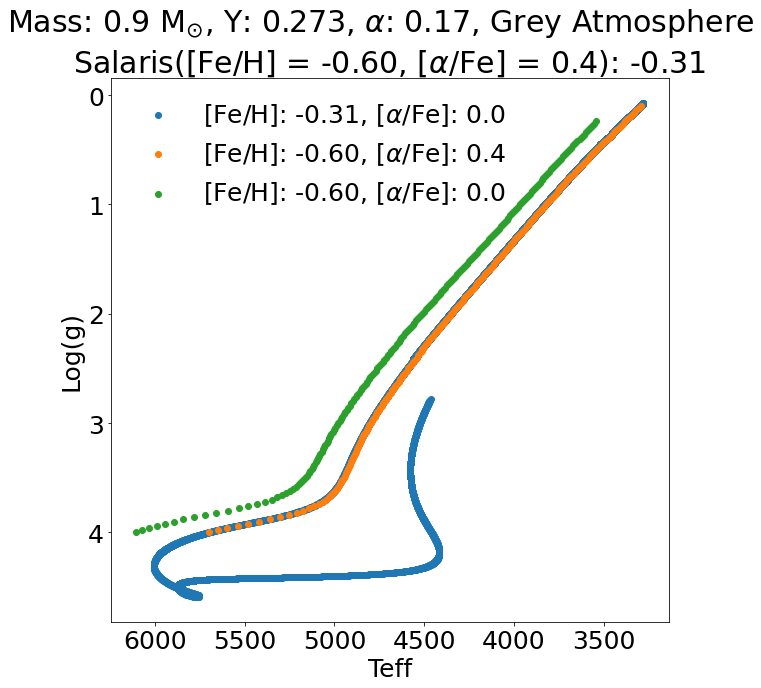

In [7]:
### Salaris [Fe/H] for [Fe/H] = -0.60 alpha = 0.4
plt.figure(figsize=[10,10])
plt.scatter(10**j031al00['col7'],j031al00['col6'],label=r'[Fe/H]: -0.31, [$\alpha$/Fe]: 0.0')
plt.scatter(j060al04['Teff'],j060al04['logg'],label=r'[Fe/H]: -0.60, [$\alpha$/Fe]: 0.4')
plt.scatter(j060al00['Teff'],j060al00['logg'],label=r'[Fe/H]: -0.60, [$\alpha$/Fe]: 0.0')
plt.legend(frameon=False)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.suptitle(r'Mass: 0.9 M$_{\odot}$, Y: 0.273, $\alpha$: 0.17, Grey Atmosphere')
plt.title(r'Salaris([Fe/H] = -0.60, [$\alpha$/Fe] = 0.4): {:.2f}'.format(salaris(np.array([[-0.6,0.4],[0.0,0.0]]).T)[0]))
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

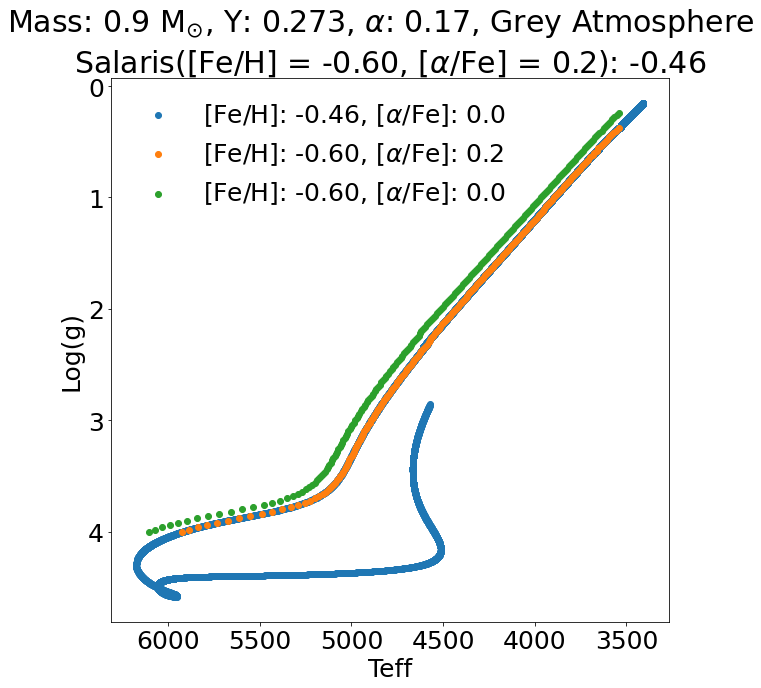

In [8]:
### Salaris [Fe/H] for [Fe/H] = -0.60 alpha = 0.2
plt.figure(figsize=[10,10])
plt.scatter(10**j046al00['col7'],j046al00['col6'],label=r'[Fe/H]: -0.46, [$\alpha$/Fe]: 0.0')
plt.scatter(j060al02['Teff'],j060al02['logg'],label=r'[Fe/H]: -0.60, [$\alpha$/Fe]: 0.2')
plt.scatter(j060al00['Teff'],j060al00['logg'],label=r'[Fe/H]: -0.60, [$\alpha$/Fe]: 0.0')
plt.legend(frameon=False)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.suptitle(r'Mass: 0.9 M$_{\odot}$, Y: 0.273, $\alpha$: 0.17, Grey Atmosphere')
plt.title(r'Salaris([Fe/H] = -0.60, [$\alpha$/Fe] = 0.2): {:.2f}'.format(salaris(np.array([[-0.6,0.2],[0.0,0.0]]).T)[0]))
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')
plt.show()

# Calculate Salaris Correction

In [9]:
salCNfeh = 999999.0*np.ones(len(kasc3dr17))
salfeh = 999999.0*np.ones(len(kasc3dr17))
salNoNefeh = 999999.0*np.ones(len(kasc3dr17))

salCNfeh_err = 999999.0*np.ones(len(kasc3dr17))
salfeh_err = 999999.0*np.ones(len(kasc3dr17))
salNoNefeh_err = 999999.0*np.ones(len(kasc3dr17))

apoafe = kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H']
apoafe_err = np.sqrt(kasc3dr17['ALPHA_M_ERR']**2+kasc3dr17['M_H_ERR']**2+kasc3dr17['FE_H_ERR']**2) 

for i in tqdm_notebook(range(len(kasc3dr17))):
    abCN = np.array([[kascdr17['FE_H'][i],kascdr17['C_FE'][i],kascdr17['N_FE'][i],
                      kascdr17['O_FE'][i],kascdr17['MG_FE'][i],kascdr17['SI_FE'][i],
                      kascdr17['S_FE'][i],kascdr17['CA_FE'][i],kascdr17['TI_FE'][i]],
                     [kascdr17['FE_H_ERR'][i],kascdr17['C_FE_ERR'][i],
                      kascdr17['N_FE_ERR'][i],kascdr17['O_FE_ERR'][i],
                      kascdr17['MG_FE_ERR'][i],kascdr17['SI_FE_ERR'][i],
                      kascdr17['S_FE_ERR'][i],kascdr17['CA_FE_ERR'][i],
                      kascdr17['TI_FE_ERR'][i]]]).T
    
    ab = np.array([[kasc3dr17['FE_H'][i],apoafe[i]],
                   [kasc3dr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    
    abNoNe = np.array([[kascdr17['FE_H'][i],kascdr17['O_FE'][i],kascdr17['MG_FE'][i],
                        kascdr17['SI_FE'][i],kascdr17['S_FE'][i],kascdr17['CA_FE'][i],
                        kascdr17['TI_FE'][i]],
                       [kascdr17['FE_H_ERR'][i],kascdr17['O_FE_ERR'][i],kascdr17['MG_FE_ERR'][i],
                        kascdr17['SI_FE_ERR'][i],kascdr17['S_FE_ERR'][i],kascdr17['CA_FE_ERR'][i],
                        kascdr17['TI_FE_ERR'][i]]]).T
    
    salCNfeh[i], salCNfeh_err[i] = salarisCN(abCN)
    salfeh[i], salfeh_err[i] = salaris(ab)
    salNoNefeh[i], salNoNefeh_err[i] = salarisNoNe(abNoNe)
    
corrfacCN = np.subtract(salCNfeh,kasc3dr17['FE_H'])
corrfac = np.subtract(salfeh,kasc3dr17['FE_H'])
corrfacNoNe = np.subtract(salNoNefeh,kasc3dr17['FE_H'])

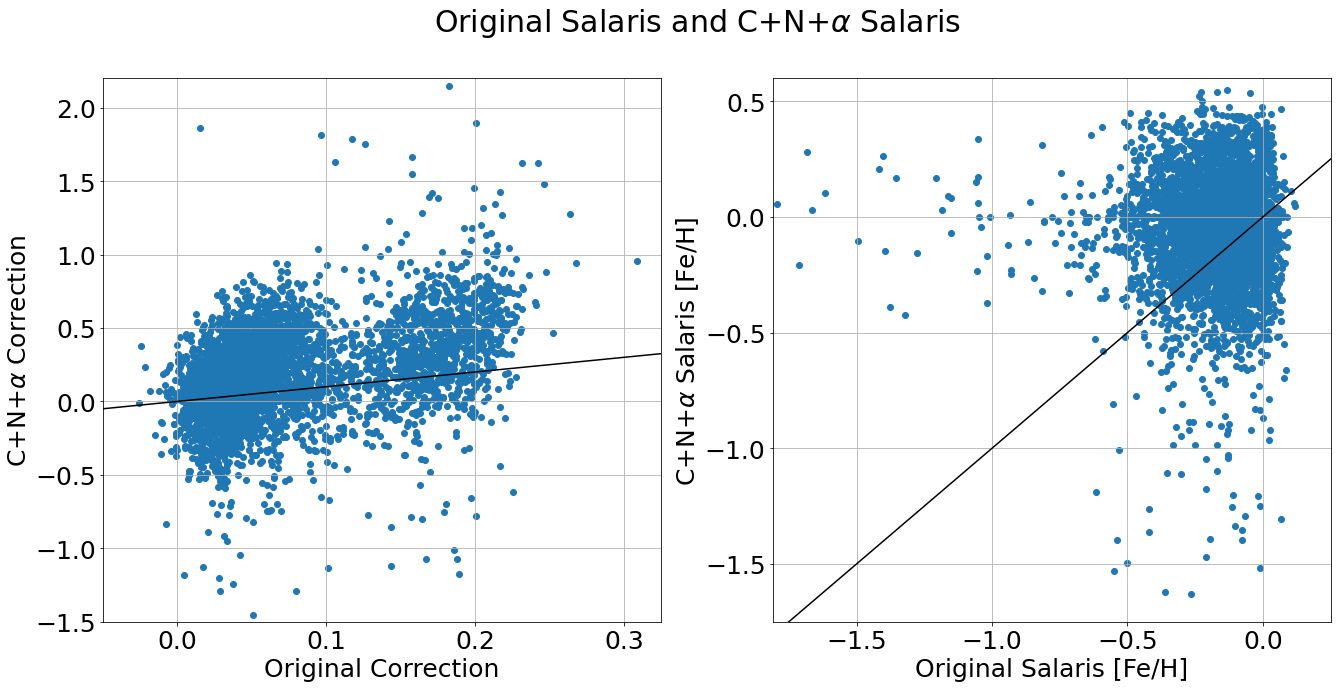

In [10]:
plt.figure(figsize=[22,10])
plt.suptitle(r'Original Salaris and C+N+$\alpha$ Salaris')

plt.subplot(121)
plt.scatter(corrfac,corrfacCN)
plt.plot([-1.5,2.2],[-1.5,2.2],c='k')
plt.grid()
plt.xlim(-0.05,0.325)
plt.ylim(-1.5,2.2)
plt.xlabel(r'Original Correction')
plt.ylabel(r'C+N+$\alpha$ Correction')

plt.subplot(122)
plt.scatter(salfeh,salCNfeh)
plt.plot([-1.81,0.6],[-1.81,0.6],c='k')
plt.grid()
plt.xlim(-1.81,0.25)
plt.ylim(-1.75,0.6)
plt.xlabel(r'Original Salaris [Fe/H]')
plt.ylabel(r'C+N+$\alpha$ Salaris [Fe/H]')
plt.savefig('../plots/Orig_CNAlpha.pdf',dpi=300,bbox_inches='tight')
plt.show()

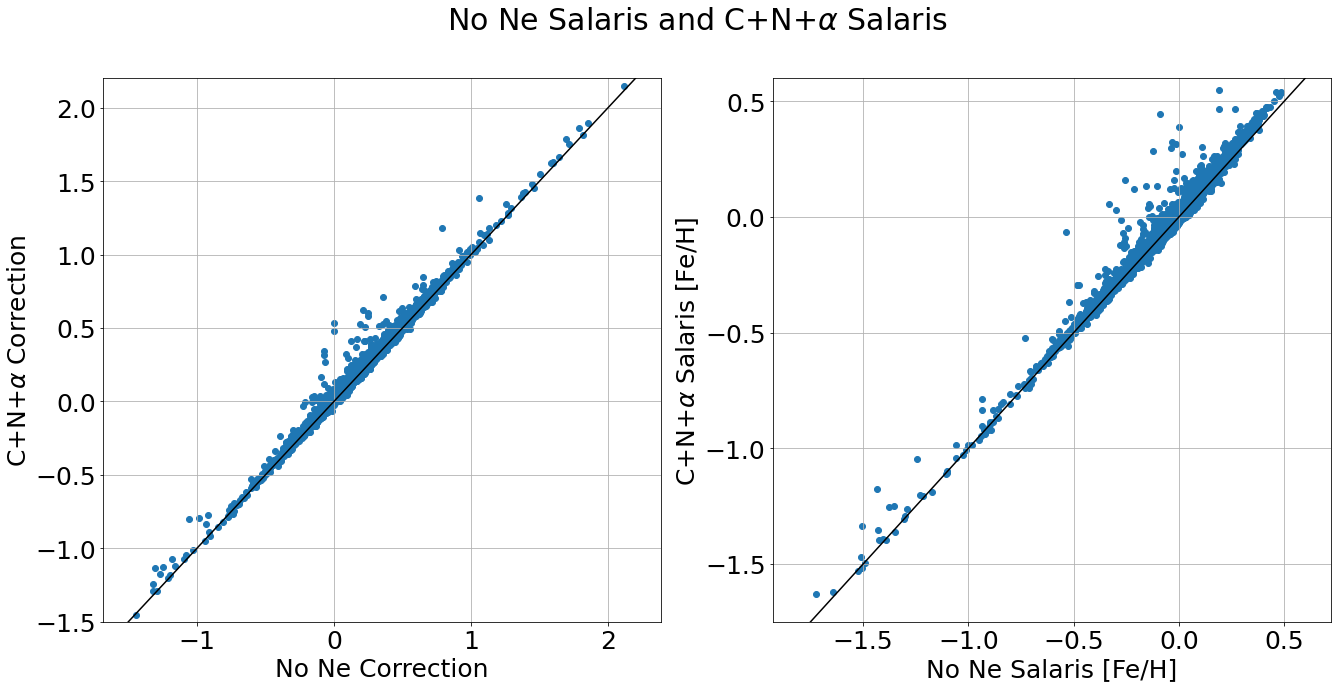

In [11]:
plt.figure(figsize=[22,10])
plt.suptitle(r'No Ne Salaris and C+N+$\alpha$ Salaris')

plt.subplot(121)
plt.scatter(corrfacNoNe,corrfacCN)
plt.plot([-1.5,2.2],[-1.5,2.2],c='k')
plt.grid()
# plt.xlim(-0.05,0.325)
plt.ylim(-1.5,2.2)
plt.xlabel(r'No Ne Correction')
plt.ylabel(r'C+N+$\alpha$ Correction')

plt.subplot(122)
plt.scatter(salNoNefeh,salCNfeh)
plt.plot([-1.81,0.6],[-1.81,0.6],c='k')
plt.grid()
# plt.xlim(-1.81,0.25)
plt.ylim(-1.75,0.6)
plt.xlabel(r'No Ne Salaris [Fe/H]')
plt.ylabel(r'C+N+$\alpha$ Salaris [Fe/H]')
plt.savefig('../plots/NoNe_CNAlpha.pdf',dpi=300,bbox_inches='tight')
plt.show()

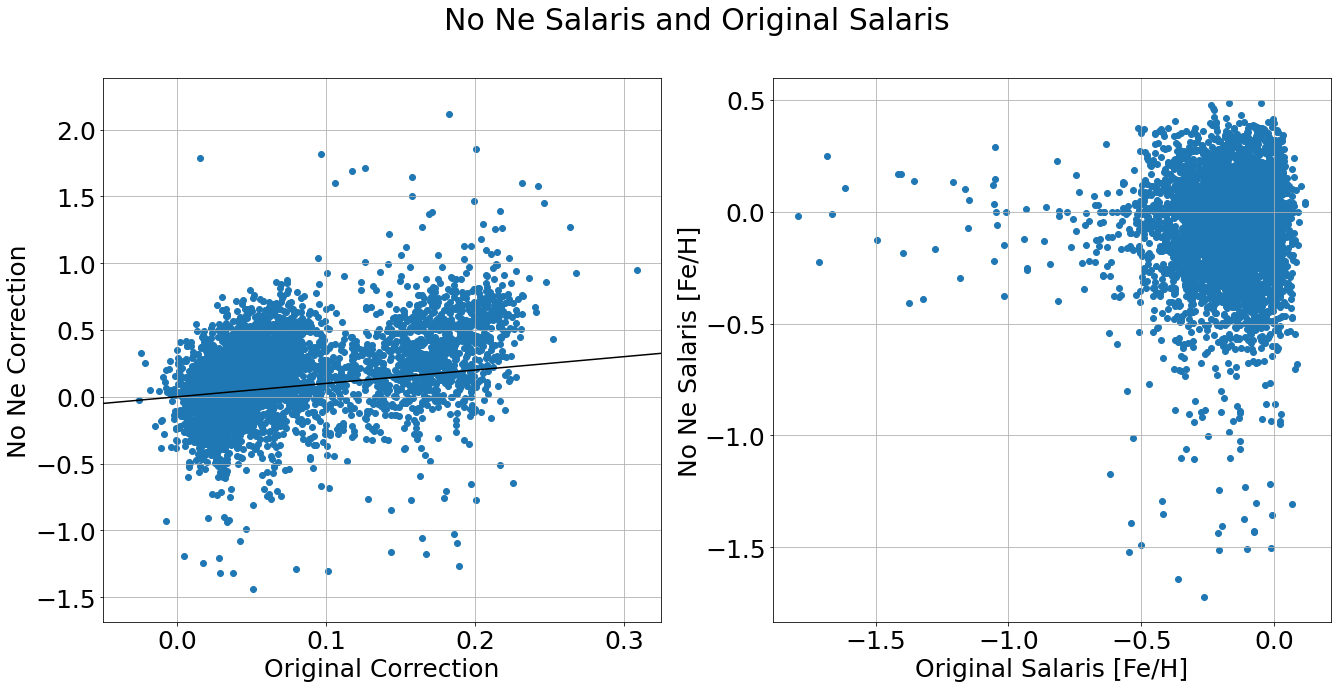

In [12]:
plt.figure(figsize=[22,10])
plt.suptitle(r'No Ne Salaris and Original Salaris')

plt.subplot(121)
plt.scatter(corrfac,corrfacNoNe)
plt.plot([-1.5,2.2],[-1.5,2.2],c='k')
plt.grid()
plt.xlim(-0.05,0.325)
# plt.ylim(-1.5,2.2)
plt.ylabel(r'No Ne Correction')
plt.xlabel(r'Original Correction')

plt.subplot(122)
plt.scatter(salfeh,salNoNefeh)
# plt.plot([-1.81,0.6],[-1.81,0.6],c='k')
plt.grid()
# plt.xlim(-1.81,0.25)
# plt.ylim(-1.75,0.6)
plt.ylabel(r'No Ne Salaris [Fe/H]')
plt.xlabel(r'Original Salaris [Fe/H]')
plt.savefig('../plots/Orig_NoNe.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [13]:
# def salaris(abund,cn=False):
#     '''
#     Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
#     Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
#     Inputs:
#     ------
#         abund: [7x2 array] or [9x2 array] first column is [Fe/H],([C/Fe],[N/Fe]),[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],
#         [Ca/Fe],[Ti/Fe] and second column is the errors. [C/Fe] and [N/Fe] are optional but if one is included 
#         the other must be included.
        
#     Output:
#     ------
#         calc_salfeh: Salaris corrected metallicity
#         calc_salfeh_err: error in corrected metallicity
#     '''
    
#     ### Replace bad values with solar 0.0, separate out Fe, and add Ne
#     for i in range(9):
#         if abund[i,0] < -10. or abund[i,0] > 10. or np.isfinite(abund[i,0])==False:
#             abund[i,0] = 0.0
#         if abund[i,1] < -10. or abund[i,1] > 10. or np.isfinite(abund[i,1])==False:
#             abund[i,1] = 0.0 
            
#     feh = abund[0,0]
#     feh_err = abund[0,1]
#     alpha = np.insert(abund[1:,0],3,np.nanmean(abund[1:,0])) # Add in Ne as avg alpha
#     alpha_err = np.insert(abund[1:,1],3,np.nanmean(abund[1:,1])) # Add in Ne as avg alpha error
    
#     ### Calculate Salaris Corrected Metallicity
#     h_mass = 1.008 # IUPAC
#     ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
#     nsamples = 1000.
#     salfehdist = 999999.0*np.ones
    
#     if cn = True:
#         ### Calculate Salaris coefficients with C, N, O, Mg, Si, S, Ca, & Ti
#         cn_asplund = np.array([8.43,7.83,8.69,7.93,7.60,7.51,7.12,6.34,4.95])
#         cn_mass_ratio = np.array([12.011,14.007,15.999,20.1797,24.305,28.085,32.06,40.078,47.867])/h_mass # IUPAC
#         cn_XZ_k = np.multiply(10**(cn_asplund-12.0),cn_mass_ratio/ZX_sol)
#         cn_sal_a = np.sum(cn_XZ_k) # Salaris a coefficient
#         cn_sal_b = 1 - cn_sal_a # Salaris b coefficient
        
#         cn_wgts = cn_asplund/np.sum(cn_asplund)
        
#         cn_noisyfeh = np.random.normal(feh,feh_err,nsamples)
        
#         for i in range(nsamples):
#             ### Add noise to the alpha abundances
#             cn_noisyalpha = 999999.0*np.ones(len(alpha))
#             for j in range(len(alpha)):
#                 cn_noisyalpha[j] = np.random.normal(alpha[j],alpha_err[j])
            
#             ### Calculate the alpha abundance
#             cn_afe = np.log10(np.sum(np.multiply(10**cn_noisyalpha,cn_wgts)))
#             salfehdist[i] = cn_noisyfeh[i] + np.log10(cn_sal_a*10**(cn_afe)+cn_sal_b)
        
#         calc_salfeh = np.nanmedian(salfehdist) # Median
#         calc_salfeh_err = np.nanmedian(np.abs(salfehdist-np.nanmedian(salfehdist))) # MAD
        
#         return calc_salfeh, calc_salfeh_err
        
#     else:
#         ### Calculate Salaris coefficients with O, Mg, Si, S, Ca, & Ti
#         asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
#         mass_ratio = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867])/h_mass # IUPAC
#         XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
#         sal_a = np.sum(XZ_k) # Salaris a coefficient
#         sal_b = 1 - sal_a # Salaris b coefficient
        
#         wgts = asplund/np.sum(asplund)
        
#         noisyfeh = np.random.normal(feh,feh_err,nsamples)
        
#         for i in range(nsamples):
#             ### Add noise to the alpha abundances
#             noisyalpha = 999999.0*np.ones(len(alpha))
#             for j in range(len(alpha)):
#                 noisyalpha[j] = np.random.normal(alpha[j],alpha_err[j])
            
#             ### Calculate the alpha abundance
#             afe = np.log10(np.sum(np.multiply(10**noisyalpha,wgts)))
#             salfehdist[i] = noisyfeh[i] + np.log10(sal_a*10**(afe)+sal_b)
        
#         calc_salfeh = np.nanmedian(salfehdist) # Median
#         calc_salfeh_err = np.nanmedian(np.abs(salfehdist-np.nanmedian(salfehdist))) # MAD
        
#         return calc_salfeh, calc_salfeh_err

In [14]:
import salaris as sal

Text(0, 0.5, 'Salaris [Fe/H] Correction, C+N+alpha')

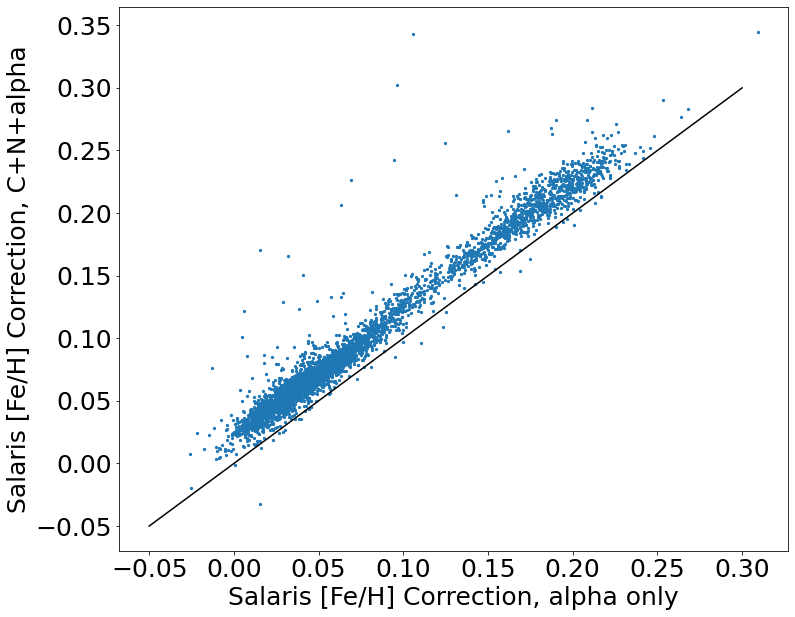

In [15]:
alpha = kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H']
feh = kasc3dr17['FE_H']
cfe = kasc3dr17['C_FE']
nfe = kasc3dr17['N_FE']
salfeh = sal.salarisfeh(feh,alpha)
salcnafeh = np.zeros(len(alpha),float)
for i in range(len(alpha)):
    salcnafeh[i] = sal.salariscna(np.array([feh[i],cfe[i],nfe[i],alpha[i]]))

plt.figure(figsize=[12,10])
plt.scatter(salfeh-feh,salcnafeh-feh,s=5)
plt.plot([-0.05,0.3],[-0.05,0.3],c='black')
plt.xlabel('Salaris [Fe/H] Correction, alpha only')
plt.ylabel('Salaris [Fe/H] Correction, C+N+alpha')

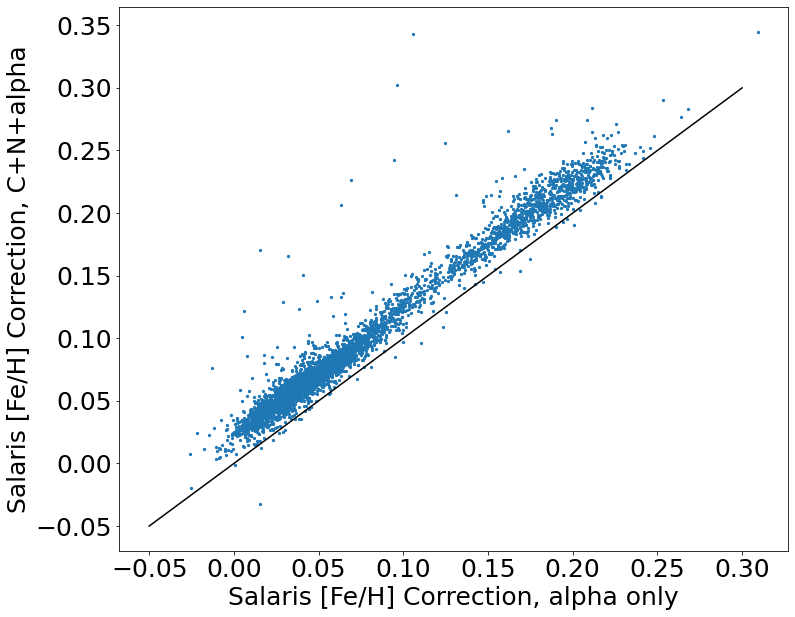

In [16]:
alpha = kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H']
feh = kasc3dr17['FE_H']
cfe = kasc3dr17['C_FE']
nfe = kasc3dr17['N_FE']

alpha_err = np.sqrt(kasc3dr17['ALPHA_M_ERR']**2+kasc3dr17['M_H_ERR']**2+kasc3dr17['FE_H']**2)
feh_err = kasc3dr17['FE_H_ERR']
cfe_err = kasc3dr17['C_FE_ERR']
nfe_err = kasc3dr17['N_FE_ERR']

salfeh = sal.salarisfeh(feh,alpha)
salcnafeh = np.zeros(len(alpha),float)
for i in range(len(alpha)):
    salcnafeh[i],_ = sal.salariscna(np.array([feh[i],cfe[i],nfe[i],alpha[i]]),
                                  np.array([feh_err[i],cfe_err[i],nfe_err[i],alpha_err[i]]))

plt.figure(figsize=[12,10])
plt.scatter(salfeh-feh,salcnafeh-feh,s=5)
plt.plot([-0.05,0.3],[-0.05,0.3],c='black')
plt.xlabel('Salaris [Fe/H] Correction, alpha only')
plt.ylabel('Salaris [Fe/H] Correction, C+N+alpha');

In [17]:
dsalfeh = 999999.0*np.ones(len(kasc3dr17))
dsalfeh_err = 999999.0*np.ones(len(kasc3dr17))
for i in tqdm_notebook(range(len(kasc3dr17))):
    dsalfeh[i], dsalfeh_err[i] = sal.salariscna(np.array([kasc3dr17['FE_H'][i],kasc3dr17['C_FE'][i],kasc3dr17['N_FE'][i],apoafe[i]]),
                   np.array([kasc3dr17['FE_H_ERR'][i],kasc3dr17['C_FE_ERR'][i],kasc3dr17['N_FE_ERR'][i],apoafe_err[i]]))

In [18]:
dsalfeh

array([-0.13507141, -0.12400885, -0.18294586, ...,  0.05935735,
       -0.02263343,  0.00227978])

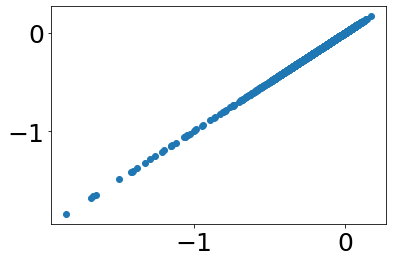

In [19]:
plt.scatter(dsalfeh,salcnafeh)

In [20]:
def salarisCNNe(abund):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.

    Inputs:
    ------
        abund: [9x2 array] first column is [Fe/H],[C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe] 
        and second column is the errors

    Output:
    ------
        salfeh: Salaris corrected metallicity
    '''

    ### Salaris coefficients
    # (atomic_wgts/hydrogen_wgt) = (C,N,O,Mg,Si,S,Ca,Ti)/H
    asplund = np.array([8.43,7.83,8.69,7.93,7.60,7.51,7.12,6.34,4.95])
    mass_ratio = np.array([12.011,14.007,15.999,20.1797,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC
    ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
    XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
    sal_a = np.sum(XZ_k)
    sal_b = 1 - sal_a

    ### C+N+Alpha
    wgts = asplund/np.sum(asplund)

    # Replace bad values with solar
    for i in range(len(abund[:,0])):
        if abund[i,0] < -10. or abund[i,0] > 10. or np.isfinite(abund[i,0])==False:
            abund[i,0] = 0.0
        if abund[i,1] < -10. or abund[i,1] > 10. or np.isfinite(abund[i,1])==False:
            abund[i,1] = 0.0 

    ### MC for Salaris Correction
    feh = abund[0,0]
    feh_err = abund[0,1]
    cnalpha = abund[1:,0]
    cnalpha_err = abund[1:,1]

    nsamples = 1000
    salfehdist = 999999.0*np.ones(nsamples)

    noisyfeh = np.random.normal(feh,feh_err,nsamples)
    for i in range(nsamples):

        noisycnalpha = 999999.0*np.ones(len(cnalpha))
        for j in range(len(cnalpha)):
            noisycnalpha[j] = np.random.normal(cnalpha[j],cnalpha_err[j])

        cnafe = np.log10(np.sum(np.multiply(10**noisycnalpha,wgts)))
        salfehdist[i] = noisyfeh[i] + np.log10(sal_a*10**(cnafe)+sal_b)

    calc_salfeh = np.nanmedian(salfehdist)
    calc_salfeh_err = mad(salfehdist)

    return calc_salfeh, calc_salfeh_err

In [21]:
salCNNefeh = 999999.0*np.ones(len(kasc3dr17))
salCNNefeh_err = 999999.0*np.ones(len(kasc3dr17))

apoafe = kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H']
apoafe_err = np.sqrt(kasc3dr17['ALPHA_M_ERR']**2+kasc3dr17['M_H_ERR']**2+kasc3dr17['FE_H_ERR']**2) 

for i in tqdm_notebook(range(len(kasc3dr17))):
    abCNNe = np.array([[kascdr17['FE_H'][i],kascdr17['C_FE'][i],kascdr17['N_FE'][i],
                      kascdr17['O_FE'][i],np.mean(apoafe[i]),kascdr17['MG_FE'][i],kascdr17['SI_FE'][i],
                      kascdr17['S_FE'][i],kascdr17['CA_FE'][i],kascdr17['TI_FE'][i]],
                     [kascdr17['FE_H_ERR'][i],kascdr17['C_FE_ERR'][i],
                      kascdr17['N_FE_ERR'][i],kascdr17['O_FE_ERR'][i],apoafe_err[i],
                      kascdr17['MG_FE_ERR'][i],kascdr17['SI_FE_ERR'][i],
                      kascdr17['S_FE_ERR'][i],kascdr17['CA_FE_ERR'][i],
                      kascdr17['TI_FE_ERR'][i]]]).T
    salCNNefeh[i], salCNNefeh_err[i] = salarisCNNe(abCNNe)

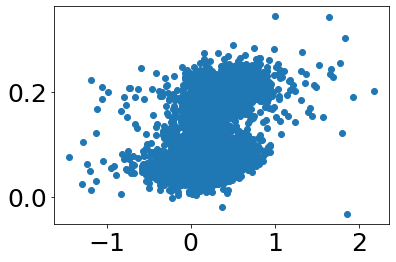

In [22]:
plt.scatter(salCNNefeh-kasc3dr17['FE_H'],salcnafeh-feh)

In [23]:
def calculate_cnafe(abund):
    asplund = np.array([8.43,7.83,8.69,7.93,7.60,7.51,7.12,6.34,4.95])
    wgts = asplund/np.sum(asplund)

    # Replace bad values with solar
    for i in range(len(abund)):
        if abund[i] < -10. or abund[i] > 10. or np.isfinite(abund[i])==False:
            abund[i] = 0.0

    cnafe = np.log10(np.sum(np.multiply(10**abund,wgts)))
    return cnafe

In [24]:
calc_afe = 999999.0*np.ones(len(kasc3dr17))
for i in range(len(calc_afe)):
    calc_afe[i] = calculate_cnafe(np.array([kasc3dr17['C_FE'][i],kasc3dr17['N_FE'][i],kasc3dr17['O_FE'][i],
                                          apoafe[i],kasc3dr17['MG_FE'][i],kasc3dr17['SI_FE'][i],
                                          kasc3dr17['S_FE'][i],kasc3dr17['CA_FE'][i],kasc3dr17['TI_FE'][i]]))

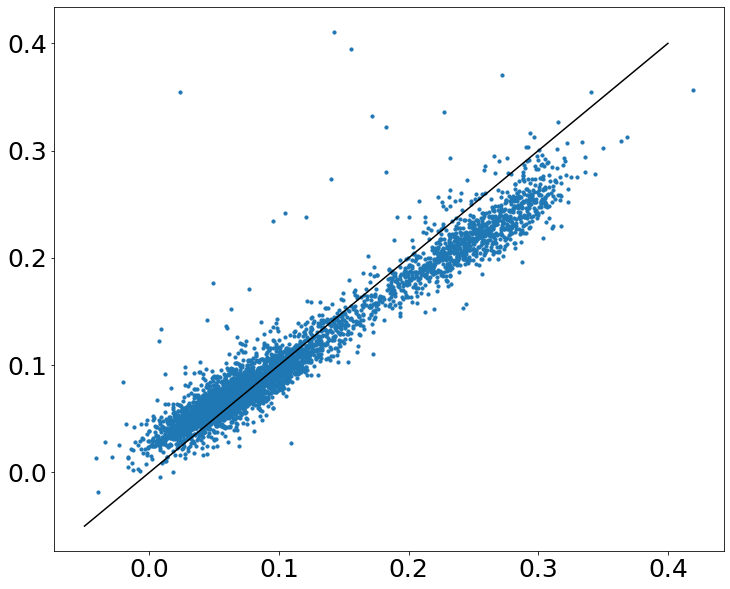

In [25]:
plt.figure(figsize=[12,10])
plt.scatter(apoafe,calc_afe,s=10)
plt.plot([-0.05,0.4],[-0.05,0.4],c='black')

In [26]:
apoafe

array([0.23804502, 0.189135  , 0.23408501, ..., 0.0769513 , 0.053651  ,
       0.048603  ], dtype=float32)

In [27]:
asplund = np.array([8.43,7.83,8.69,7.93,7.60,7.51,7.12,6.34,4.95])
mass_ratio = np.array([12.011,14.007,15.999,20.1797,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC
ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
sal_a = np.sum(XZ_k)
sal_b = 1 - sal_a
print(sal_a)
print(sal_b)

0.8837765757796034
0.11622342422039655


In [28]:
asplund = np.array([8.43,7.83,8.69,7.93,7.60,7.51,7.12,6.34,4.95])
mass_ratio = np.array([12.011,14.007,15.999,20.1797,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC    
ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
sal_a = np.sum(XZ_k)
sal_b = 1 - sal_a

print(sal_a)
print(sal_b)

0.8837765757796034
0.11622342422039655


Text(0, 0.5, 'Salaris Correction Factor, C+N+Alpha Only')

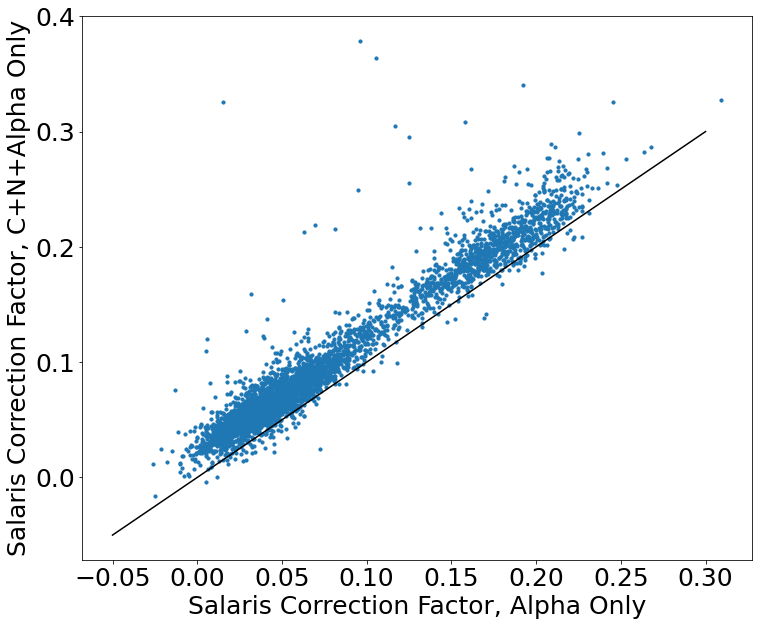

In [29]:
plt.figure(figsize=[12,10])
plt.scatter(np.log10(0.638*10**apoafe+0.362),np.log10(0.8837765757796034*(10**calc_afe)+0.11622342422039655),s=10)
plt.plot([-0.05,0.3],[-0.05,0.3],c='black')

plt.xlabel(r'Salaris Correction Factor, Alpha Only')
plt.ylabel(r'Salaris Correction Factor, C+N+Alpha Only')

Text(0, 0.5, 'Salaris Correction Factor, C+N+Alpha Me')

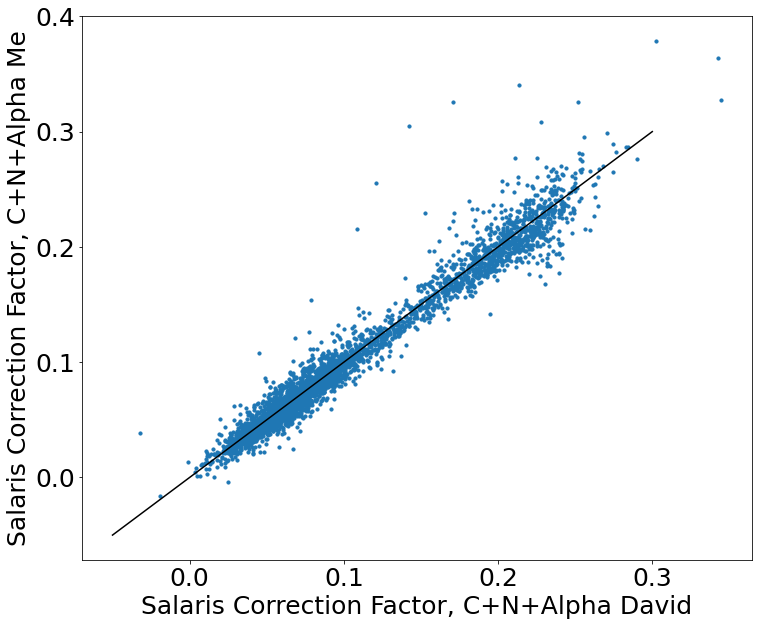

In [30]:
plt.figure(figsize=[12,10])
plt.scatter(salcnafeh-feh,np.log10(0.8837765757796034*(10**calc_afe)+0.11622342422039655),s=10)
plt.plot([-0.05,0.3],[-0.05,0.3],c='black')

plt.xlabel(r'Salaris Correction Factor, C+N+Alpha David')
plt.ylabel(r'Salaris Correction Factor, C+N+Alpha Me')

Text(0, 0.5, 'Salaris [Fe/H], C+N+Alpha Me')

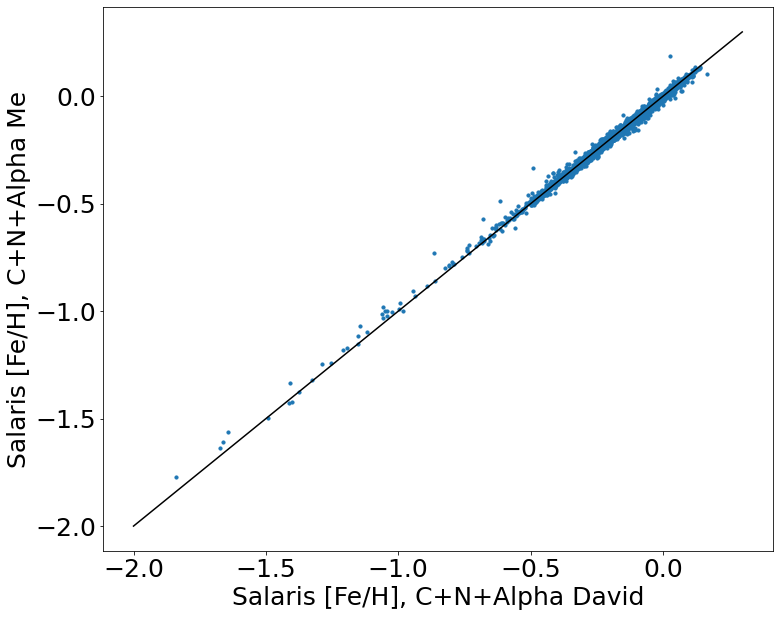

In [31]:
plt.figure(figsize=[12,10])
plt.scatter(salcnafeh,kasc3dr17['FE_H']+np.log10(0.8837765757796034*(10**calc_afe)+0.11622342422039655),s=10)
plt.plot([-2.0,0.3],[-2.0,0.3],c='black')

plt.xlabel(r'Salaris [Fe/H], C+N+Alpha David')
plt.ylabel(r'Salaris [Fe/H], C+N+Alpha Me')

In [32]:
asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
mass_ratio = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC
ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
sal_a = np.sum(XZ_k)
sal_b = 1 - sal_a
print(sal_a)
print(sal_b)

0.7896362713119607
0.21036372868803932


In [33]:
def salarisCNNe(abund):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.

    Inputs:
    ------
        abund: [9x2 array] first column is [Fe/H],[C/Fe],[N/Fe],[O/Fe],[Ne/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],
        [Ti/Fe]

    Output:
    ------
        salfeh: Salaris corrected metallicity
    '''

    ### Salaris coefficients
    # (atomic_wgts/hydrogen_wgt) = (C,N,O,Ne,Mg,Si,S,Ca,Ti)/H
    asplund = np.array([8.43,7.83,8.69,7.93,7.60,7.51,7.12,6.34,4.95])
    mass_ratio = np.array([12.011,14.007,15.999,20.1797,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC
    ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
    XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
    sal_a = np.sum(XZ_k)
    sal_b = 1 - sal_a
    
    asplund = np.array([8.43,7.83,8.69,7.93,7.60,7.51,7.12,6.34,4.95])
    wgts = asplund/np.sum(asplund)

    # Replace bad values with solar
    for i in range(len(abund)):
        if abund[i] < -10. or abund[i] > 10. or np.isfinite(abund[i])==False:
            abund[i] = 0.0

    cnafe = np.log10(np.sum(np.multiply(10**abund[1:],wgts)))
    salfeh = abund[0] + np.log10(sal_a*(10**cnafe)+sal_b)
    return salfeh

In [34]:
salCNNefeh = 999999.0*np.ones(len(kasc3dr17))

apoafe = kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H']
# apoafe_err = np.sqrt(kasc3dr17['ALPHA_M_ERR']**2+kasc3dr17['M_H_ERR']**2+kasc3dr17['FE_H_ERR']**2) 

for i in tqdm_notebook(range(len(kasc3dr17))):
    abCNNe = np.array([kasc3dr17['FE_H'][i],kasc3dr17['C_FE'][i],kasc3dr17['N_FE'][i],kasc3dr17['O_FE'][i],
                       apoafe[i],kasc3dr17['MG_FE'][i],kasc3dr17['SI_FE'][i],kasc3dr17['S_FE'][i],
                       kasc3dr17['CA_FE'][i],kasc3dr17['TI_FE'][i]])
    salCNNefeh[i] = salarisCNNe(abCNNe)

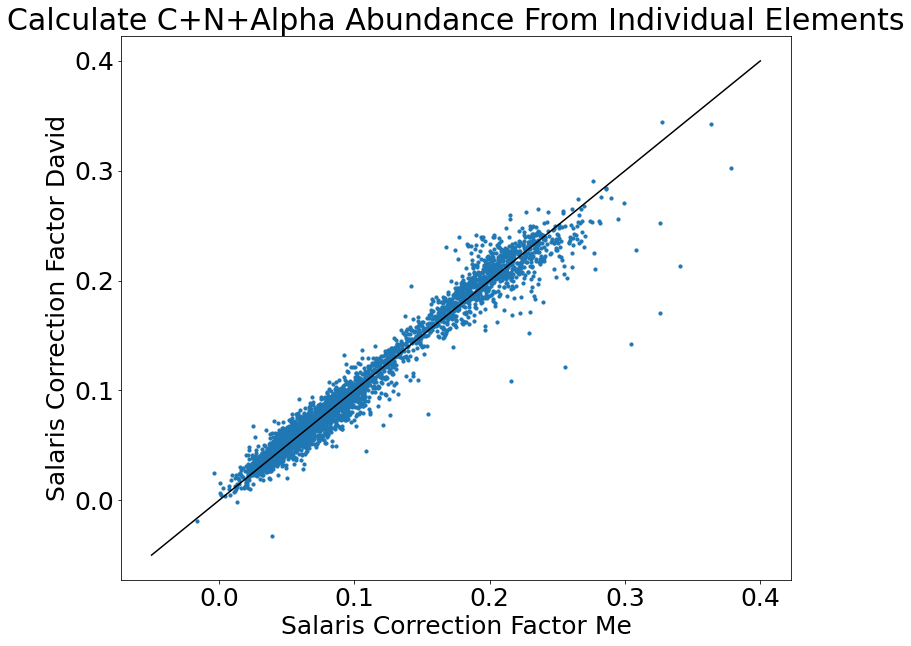

In [35]:
plt.figure(figsize=[12,10])
plt.scatter(salCNNefeh-kasc3dr17['FE_H'],salcnafeh-feh,s=10)
plt.plot([-0.05,0.4],[-0.05,0.4],c='black')
plt.title(r'Calculate C+N+Alpha Abundance From Individual Elements')
plt.xlabel(r'Salaris Correction Factor Me')
plt.ylabel(r'Salaris Correction Factor David')
plt.savefig('MeFacDavidFacIndAlpha.pdf',dpi=300,bbox_inches='tight')

In [36]:
def salcnalpha(abund):
    ### Salaris coefficients
    asplund = np.array([8.43,7.83,8.69,7.93,7.60,7.51,7.12,6.34,4.95]) # Asplund et al. 2009
    mass_ratio = np.array([12.011,14.007,15.999,20.1797,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC
    ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
    XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
    sal_a = np.sum(XZ_k)
    sal_b = 1 - sal_a
    
    wgts = np.array([asplund[0],asplund[1],np.sum(asplund[2:])])/np.sum(asplund) #asplund/np.sum(asplund)

    # Replace bad values with solar
    for i in range(len(abund)):
        if abund[i] < -10. or abund[i] > 10. or np.isfinite(abund[i])==False:
            abund[i] = 0.0
            
    cnafe10 = np.sum(np.multiply(10**abund[1:],wgts))
    salfeh = abund[0] + np.log10(sal_a*(cnafe10)+sal_b)
    return salfeh

In [37]:
salCNalphafeh = 999999.0*np.ones(len(kasc3dr17))

apoafe = kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H']

for i in tqdm_notebook(range(len(kasc3dr17))):
    abCNalpha = np.array([kasc3dr17['FE_H'][i],kasc3dr17['C_FE'][i],kasc3dr17['N_FE'][i],apoafe[i]])
    salCNalphafeh[i] = salcnalpha(abCNalpha)

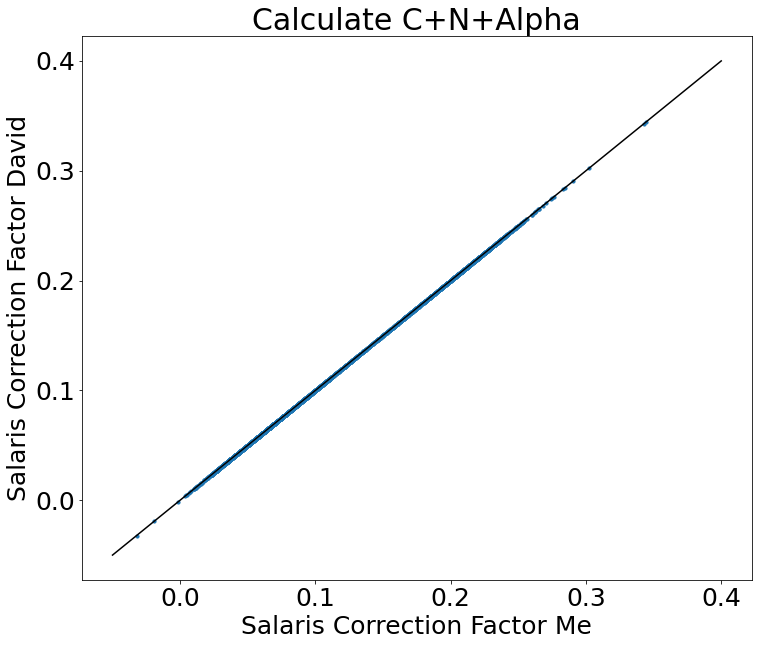

In [38]:
plt.figure(figsize=[12,10])
plt.scatter(salCNalphafeh-kasc3dr17['FE_H'],salcnafeh-feh,s=10)
plt.plot([-0.05,0.4],[-0.05,0.4],c='black')
plt.title(r'Calculate C+N+Alpha')
plt.xlabel(r'Salaris Correction Factor Me')
plt.ylabel(r'Salaris Correction Factor David')
plt.savefig('MeFacDavidFacCNAlpha.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [39]:
def salcnalpha(abund,abunderr=None):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.

    Inputs:
    ------
        abund: [4x2 array] first column is [Fe/H],[C/Fe],[N/Fe],[Alpha/Fe]
        abunderr: [4x2 array] optional array of errors if provided the error in the output will be returned

    Output:
    ------
        salfeh: Salaris corrected metallicity
        salfeherr: error in the corrected metallicity only returned if abunderr is provided
    '''
    ### Salaris coefficients Using C, N, O, Ne, Mg, Si, S, Ca, Ti
    asplund = np.array([8.43,7.83,8.69,7.93,7.60,7.51,7.12,6.34,4.95]) # Asplund et al. 2009
    mass_ratio = np.array([12.011,14.007,15.999,20.1797,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC
    ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
    XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
    sal_a = np.sum(XZ_k)
    sal_b = 1 - sal_a

    ### Replace bad values with solar
    for i in range(len(abund)):
        if abund[i] < -10. or abund[i] > 10. or np.isfinite(abund[i])==False:
            abund[i] = 0.0
        if abund_err[i] < -10. or abund_err[i] > 10. or np.isfinite(abund_err[i])==False:
            abund_err[i] = 0.0
     
    ### Calculate [(C+N+Alpha)/Fe] and Salaris corrected [Fe/H]
    wgts = np.array([asplund[0],asplund[1],np.sum(asplund[2:])])/np.sum(asplund)
    cnafe10 = np.sum(np.multiply(10**abund[1:],wgts))
    salfeh = abund[0] + np.log10(sal_a*(cnafe10)+sal_b)
    
    ### Uncertainties
    if abunderr is not None:

        feherr = abunderr[0]
        cnafe_err = np.sqrt(np.sum((10**cnalpha*np.log(10)*abunderr[1:]*wgts)**2))
        corr_err = cnafe_err/((sal_a*cnafe*sal_b)*np.log(10))
        salfeherr = np.sqrt(feherr**2+corr_err**2)

        return salfeh, salfeherr
    
    return salfeh

In [40]:
asplund = np.array([8.43,7.83,8.69,7.93,7.60,7.51,7.12,6.34,4.95])
mass_ratio = np.array([12.011,14.007,15.999,20.1797,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC    
ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
sal_a = np.sum(XZ_k)
sal_b = 1 - sal_a
print(np.round(sal_a,3))
print(np.round(sal_b,3))

0.884
0.116


In [41]:
testasplund = np.array([8.69,7.93,7.60,7.51,7.12,6.34,4.95])
testmass_ratio = np.array([15.999,20.1797,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC    
testZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
testXZ_k = np.multiply(10**(testasplund-12.0),testmass_ratio/testZX_sol)
testsal_a = np.sum(testXZ_k)
testsal_b = 1 - testsal_a
print(testsal_a)
print(testsal_b)

0.6546816075350533
0.34531839246494667


In [42]:
import dlnpyutils.utils as dln
def salariscna(abund,abunderr=None):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
    Inputs:
    ------
    abund: [4x2 array] first column is [Fe/H],[C/Fe],[N/Fe],[alpha/Fe]
       and second column is the errors
        
    Output:
    ------
    calc_salfeh: Salaris corrected metallicity
    calc_salfeh_err: error in corrected metallicity
    '''
        
    ### Salaris coefficients
    # (atomic_wgts/hydrogen_wgt) = (C,N,O,Mg,Si,S,Ca,Ti)/H
    #asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
    #mass_ratio = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC
    # with Ne
    # (atomic_wgts/hydrogen_wgt) = (C,N,O,Ne,Mg,Si,S,Ca,Ti)/H    
    asplund = np.array([8.43,7.83,8.69,7.93,7.60,7.51,7.12,6.34,4.95])
    mass_ratio = np.array([12.011,14.007,15.999,20.1797,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC    
    ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
    XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
    sal_a = np.sum(XZ_k)
    sal_b = 1 - sal_a
        
    ### Alpha+C+N
    #wgts = asplund/np.sum(asplund)
    # add together the alpha weights
    wgts = np.array([asplund[0],asplund[1],np.sum(asplund[2:])])/np.sum(asplund)
    
    feh = abund[0]
    cnalpha = abund[1:]
    
    #cnafe = np.log10(np.sum((10**cnalpha)*wgts)))
    #salfeh = feh + np.log10(sal_a*10**(cnafe)+sal_b)

    cnafe = np.sum((10**cnalpha)*wgts)
    salfeh = feh + np.log10(sal_a*cnafe+sal_b)        
    
    # Uncertainties
    if abunderr is not None:
        feherr = abunderr[0]
        cnafe_err = np.sqrt(np.sum((10**cnalpha*np.log(10)*abunderr[1:]*wgts)**2))
        corr_err = cnafe_err/((sal_a*cnafe*sal_b)*np.log(10))
        salfeherr = np.sqrt(feherr**2+corr_err**2)

        return salfeh, salfeherr
    
    return salfeh

In [43]:
testsal = 999999.0*np.ones(len(kasc3dr17))
testsalerr = 999999.0*np.ones(len(kasc3dr17))

apoafe = kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H']
apoafeerr = np.sqrt(kasc3dr17['ALPHA_M_ERR']**2+kasc3dr17['M_H_ERR']**2+kasc3dr17['FE_H_ERR']**2)

for i in tqdm_notebook(range(len(kasc3dr17))):
    testab = np.array([kasc3dr17['FE_H'][i],kasc3dr17['C_FE'][i],kasc3dr17['N_FE'][i],apoafe[i]])
    testaberr = np.array([kasc3dr17['FE_H_ERR'][i],kasc3dr17['C_FE_ERR'][i],kasc3dr17['N_FE_ERR'][i],apoafeerr[i]])
    testsal[i],testsalerr[i] = salariscna(testab,testaberr)
    

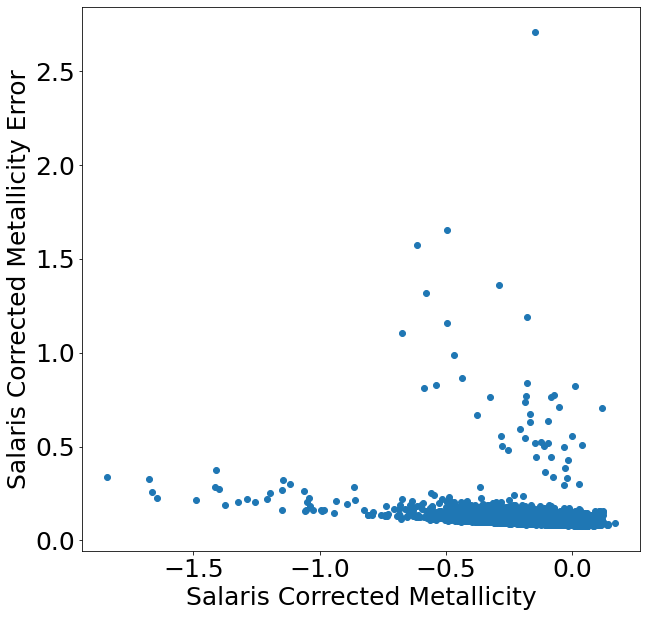

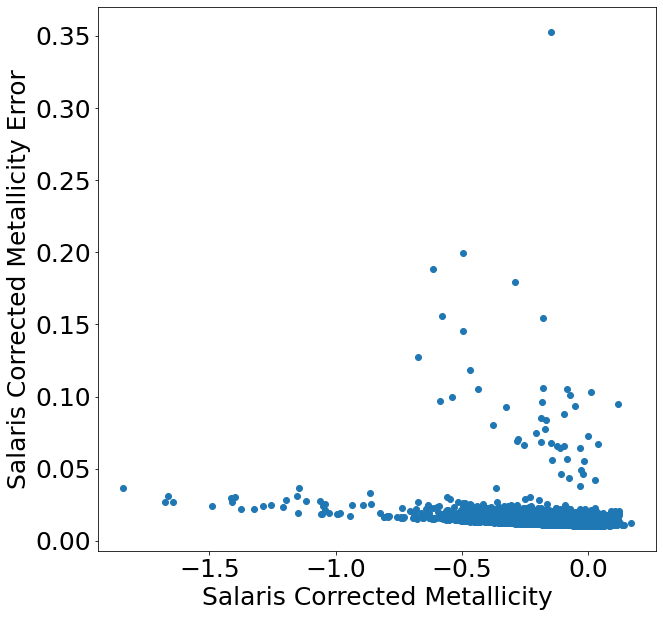

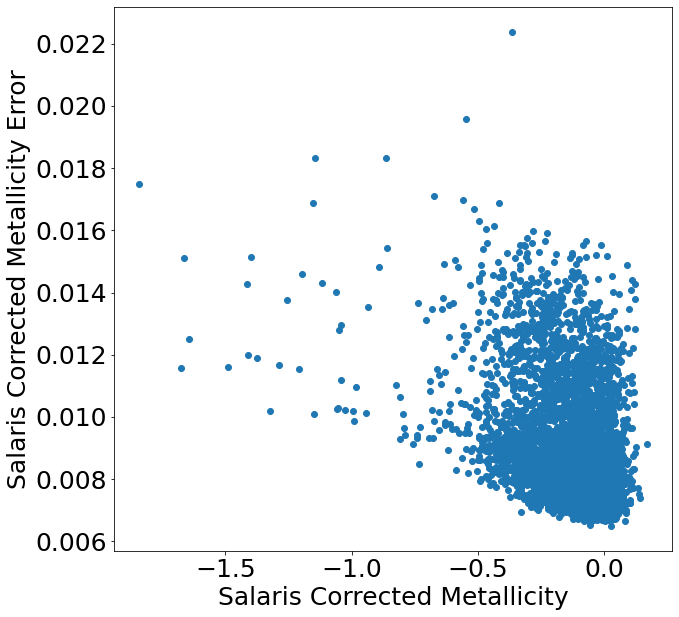

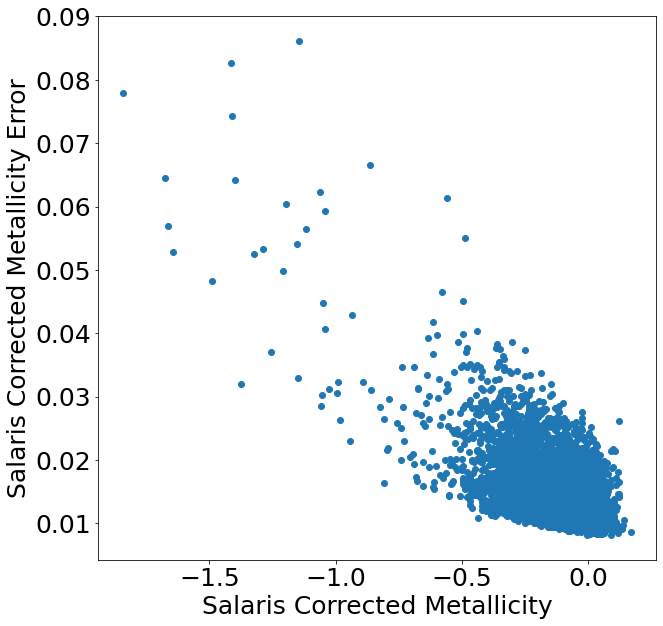

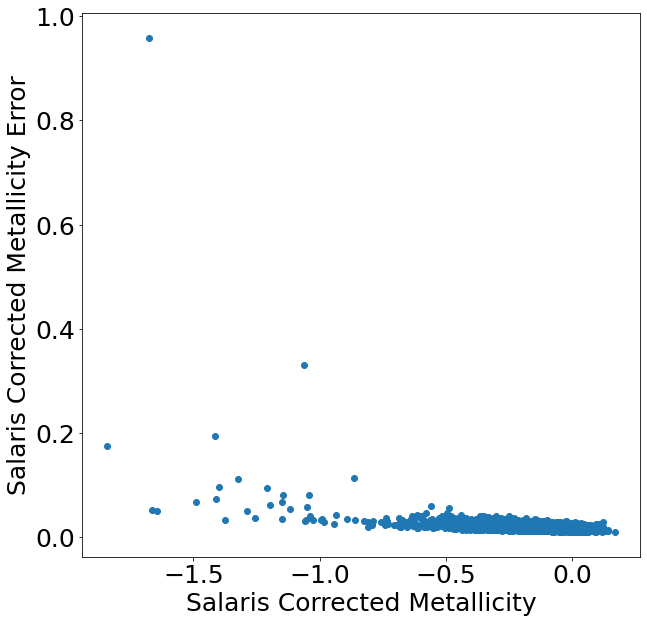

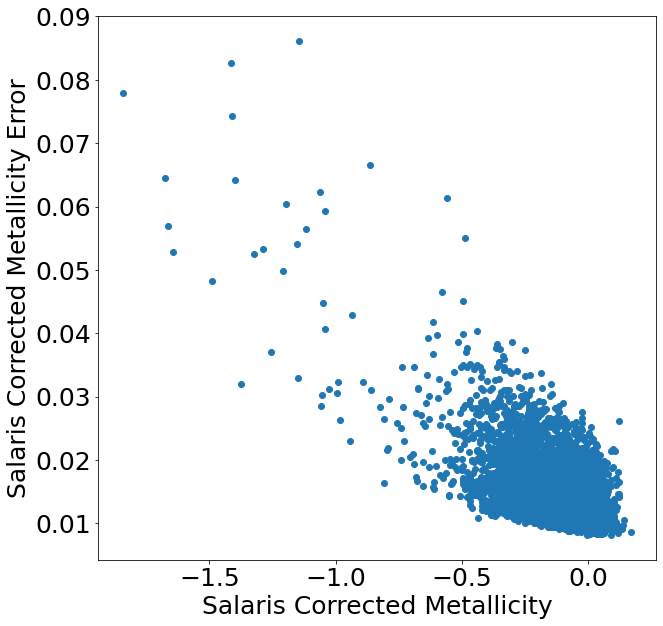

In [44]:
plt.figure(figsize=[10,10])
plt.scatter(testsal,testsalerr)
plt.xlabel(r'Salaris Corrected Metallicity')
plt.ylabel(r'Salaris Corrected Metallicity Error')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(testsal,apoafeerr)
plt.xlabel(r'Salaris Corrected Metallicity')
plt.ylabel(r'Salaris Corrected Metallicity Error')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(testsal,kasc3dr17['FE_H_ERR'])
plt.xlabel(r'Salaris Corrected Metallicity')
plt.ylabel(r'Salaris Corrected Metallicity Error')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(testsal,kasc3dr17['C_FE_ERR'])
plt.xlabel(r'Salaris Corrected Metallicity')
plt.ylabel(r'Salaris Corrected Metallicity Error')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(testsal,kasc3dr17['N_FE_ERR'])
plt.xlabel(r'Salaris Corrected Metallicity')
plt.ylabel(r'Salaris Corrected Metallicity Error')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(testsal,kasc3dr17['C_FE_ERR'])
plt.xlabel(r'Salaris Corrected Metallicity')
plt.ylabel(r'Salaris Corrected Metallicity Error')
plt.show()

In [45]:
import dlnpyutils.utils as dln
def salariscna(abund,mc=False):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
    Inputs:
    ------
    abund: [9x2 array] first column is [Fe/H],[C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe] 
       and second column is the errors
        
    Output:
    ------
    calc_salfeh: Salaris corrected metallicity
    calc_salfeh_err: error in corrected metallicity
    '''
        
    ### Salaris coefficients
    # (atomic_wgts/hydrogen_wgt) = (C,N,O,Mg,Si,S,Ca,Ti)/H
    asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
    mass_ratio = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC
    ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
    XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
    sal_a = np.sum(XZ_k)
    sal_b = 1 - sal_a
        
    ### Alpha+C+N
    wgts = asplund/np.sum(asplund)
        
    ### Replace bad values with solar
    for i in range(len(abund[:,0])):
        if abund[i,0] < -10. or abund[i,0] > 10. or np.isfinite(abund[i,0])==False:
            abund[i,0] = 0.0
        if abund[i,1] < -10. or abund[i,1] > 10. or np.isfinite(abund[i,1])==False:
            abund[i,1] = 0.0 

    feh = abund[0,0]
    feh_err = abund[0,1]
    cnalpha = abund[1:,0]
    
    cnafe = np.log10(np.sum(np.multiply(10**cnalpha,wgts)))
    salfeh = feh + np.log10(sal_a*10**(cnafe)+sal_b)    
    
    ### MC for Salaris Correction
    if mc:
        cnalpha_err = abund[1:,1]    
        nsamples = 1000
        salfehdist = 999999.0*np.ones(nsamples)
        
        noisyfeh = np.random.normal(feh,feh_err,nsamples)
        for i in range(nsamples):
            noisycnalpha = 999999.0*np.ones(len(cnalpha))
            for j in range(len(cnalpha)):
                noisycnalpha[j] = np.random.normal(cnalpha[j],cnalpha_err[j])
            
            cnafe = np.log10(np.sum(np.multiply(10**noisycnalpha,wgts)))
            salfehdist[i] = noisyfeh[i] + np.log10(sal_a*10**(cnafe)+sal_b)

        calc_salfeh_err = dln.mad(salfehdist)
        
        return salfeh, calc_salfeh_err

    return salfeh

In [46]:
mcsal = 999999.0*np.ones(len(kasc3dr17))
mcsalerr = 999999.0*np.ones(len(kasc3dr17))

apoafe = kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H']
apoafeerr = np.sqrt(kasc3dr17['ALPHA_M']**2+kasc3dr17['M_H']**2+kasc3dr17['FE_H']**2)

for i in tqdm_notebook(range(len(kasc3dr17))):
#     mcab = np.array([kasc3dr17['FE_H'][i],kasc3dr17['C_FE'][i],kasc3dr17['N_FE'][i],apoafe[i]])
#     mcaberr = np.array([kasc3dr17['FE_H_ERR'][i],kasc3dr17['C_FE_ERR'][i],kasc3dr17['N_FE_ERR'][i],apoafeerr[i]])
    
    mcab = np.array([[kasc3dr17['FE_H'][i],kasc3dr17['C_FE'][i],kasc3dr17['N_FE'][i],apoafe[i]],
                     [kasc3dr17['FE_H_ERR'][i],kasc3dr17['C_FE_ERR'][i],kasc3dr17['N_FE_ERR'][i],apoafeerr[i]]]).T
    
    mcsal[i],mcsalerr[i] = salariscna(mcab,mc=True)

ValueError: operands could not be broadcast together with shapes (3,) (8,) 

# CN or No CN Residual

In [47]:
agesCN = Table(fits.getdata('APOKASC_rgb_SalarisCNAlpha.fits'))
ages = Table(fits.getdata('APOKASC_rgb_Sal_age_ak.fits'))

### [(C+N/Fe)]
cfrac = (10**(8.43))/(10**(8.43)+10**(7.83))
nfrac = (10**(7.83))/(10**(8.43)+10**(7.83))

cnfe = np.log10(cfrac*10**(kasc3dr17['C_FE'])+nfrac*10**(kasc3dr17['N_FE']))

In [48]:
clnCN = np.where((kasc3['IntAge']-agesCN['AGE']<20.)&(cnfe>-0.1)&(cnfe<0.2))
nbins=20
cnalphafe_medians,cnalphafe_edges,_ = binned_statistic(cnfe[clnCN],(kasc3['IntAge']-agesCN['AGE'])[clnCN],
                                                       statistic='median',bins=nbins)
cln = np.where((kasc3['IntAge']-agesCN['AGE']<20.)&(cnfe>-0.1)&(cnfe<0.2))
alphafe_medians,alphafe_edges,_ = binned_statistic(cnfe[cln],(kasc3['IntAge']-ages['AGE'])[cln],
                                                       statistic='median',bins=nbins)


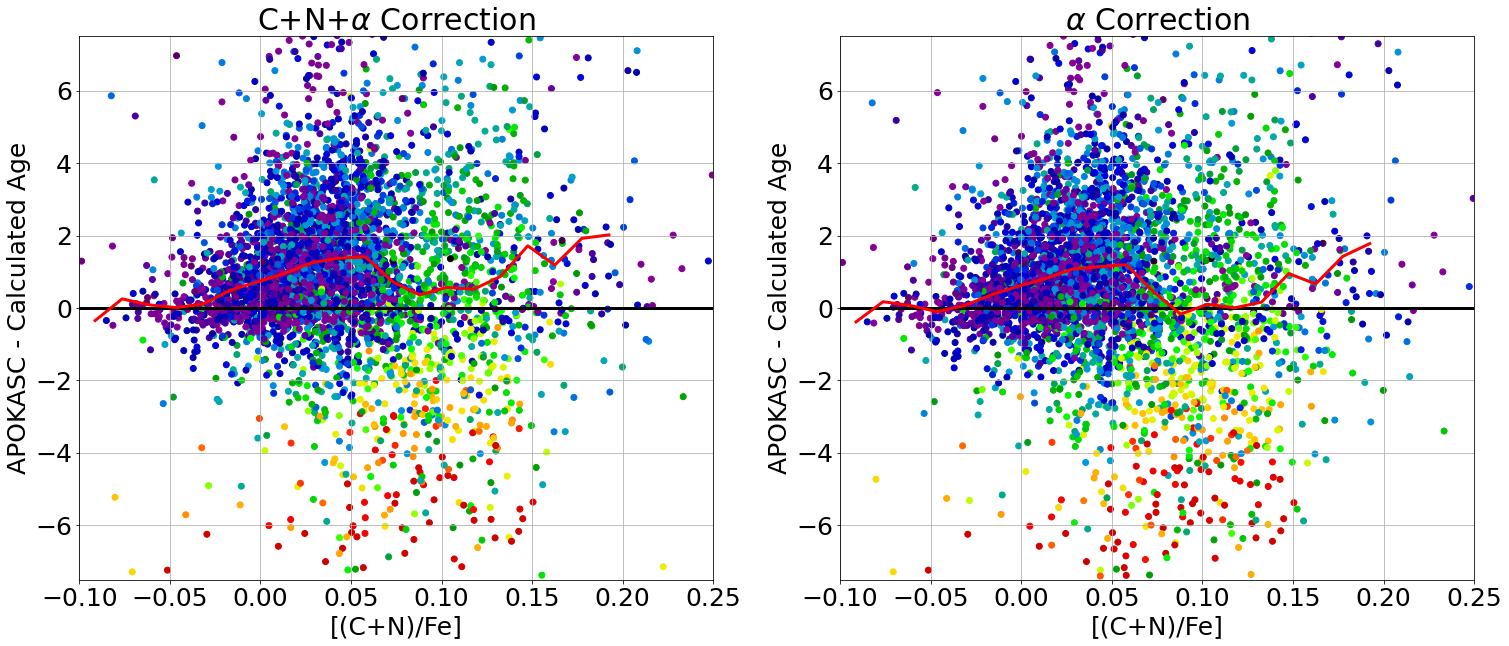

In [49]:
plt.figure(figsize=[25,10])
plt.subplot(121)
plt.scatter(cnfe,kasc3['IntAge']-agesCN['AGE'],c=agesCN['AGE'],cmap='nipy_spectral',vmax=18)
plt.axhline(0,c='k',lw=3.0)
plt.plot((cnalphafe_edges[:-1]+cnalphafe_edges[1:])/2,cnalphafe_medians,c='red',lw=3)
plt.xlim(-0.1,0.25)
plt.ylim(-7.5,7.5)
plt.grid()
plt.title(r'C+N+$\alpha$ Correction')
plt.xlabel(r'[(C+N)/Fe]')
plt.ylabel(r'APOKASC - Calculated Age')

plt.subplot(122)
plt.scatter(cnfe,kasc3['IntAge']-ages['AGE'],c=ages['AGE'],cmap='nipy_spectral',vmax=18)
plt.axhline(0,c='k',lw=3.0)
plt.plot((alphafe_edges[:-1]+alphafe_edges[1:])/2,alphafe_medians,c='red',lw=3)
plt.ylim(-7.5,7.5)
plt.xlim(-0.1,0.25)
plt.grid()
plt.title(r'$\alpha$ Correction')
plt.xlabel(r'[(C+N)/Fe]')
plt.ylabel(r'APOKASC - Calculated Age')

plt.savefig('../plots/cnfe_resid_2panels.pdf',dpi=300,bbox_inches='tight')
plt.show()

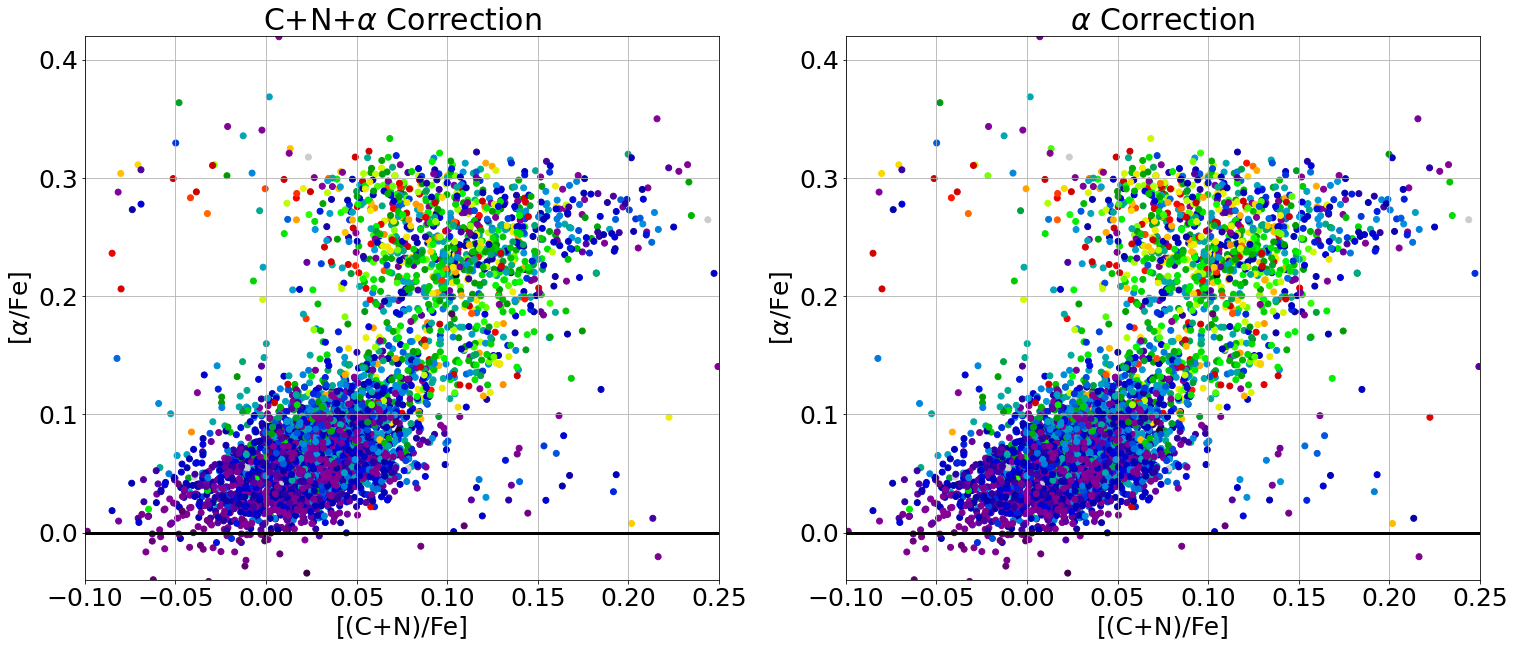

In [50]:
plt.figure(figsize=[25,10])
plt.subplot(121)
plt.scatter(cnfe,apoafe,c=agesCN['AGE'],cmap='nipy_spectral',vmax=18)
plt.axhline(0,c='k',lw=3.0)
# plt.plot((cnalphafe_edges[:-1]+cnalphafe_edges[1:])/2,cnalphafe_medians,c='red',lw=3)
plt.xlim(-0.1,0.25)
plt.ylim(-0.04,0.42)
plt.grid()
plt.title(r'C+N+$\alpha$ Correction')
plt.xlabel(r'[(C+N)/Fe]')
plt.ylabel(r'[$\alpha$/Fe]')

plt.subplot(122)
plt.scatter(cnfe,apoafe,c=ages['AGE'],cmap='nipy_spectral',vmax=18)
plt.axhline(0,c='k',lw=3.0)
# plt.plot((alphafe_edges[:-1]+alphafe_edges[1:])/2,alphafe_medians,c='red',lw=3)
plt.xlim(-0.1,0.25)
plt.ylim(-0.04,0.42)
plt.grid()
plt.title(r'$\alpha$ Correction')
plt.xlabel(r'[(C+N)/Fe]')
plt.ylabel(r'[$\alpha$/Fe]')

plt.savefig('../plots/cnfe_afe_2panels.pdf')
plt.show()

In [51]:
print(min(apoafe))
print(max(apoafe))

-0.041360997
0.41954494


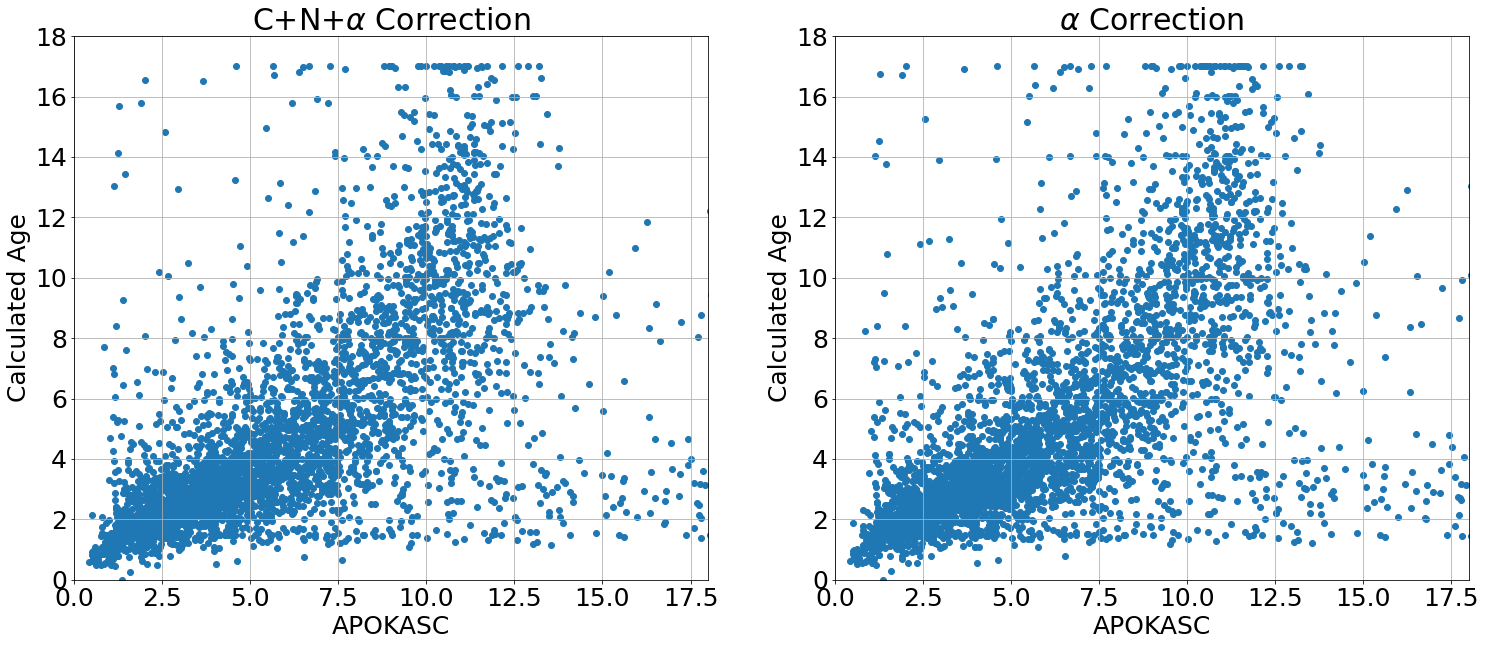

In [52]:
plt.figure(figsize=[25,10])
plt.subplot(121)
plt.scatter(kasc3['IntAge'],agesCN['AGE'])
plt.xlim(0,18)
plt.ylim(0,18)
plt.grid()
plt.title(r'C+N+$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.subplot(122)
plt.scatter(kasc3['IntAge'],ages['AGE'])
plt.ylim(0,18)
plt.xlim(0,18)
plt.grid()
plt.title(r'$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.show()

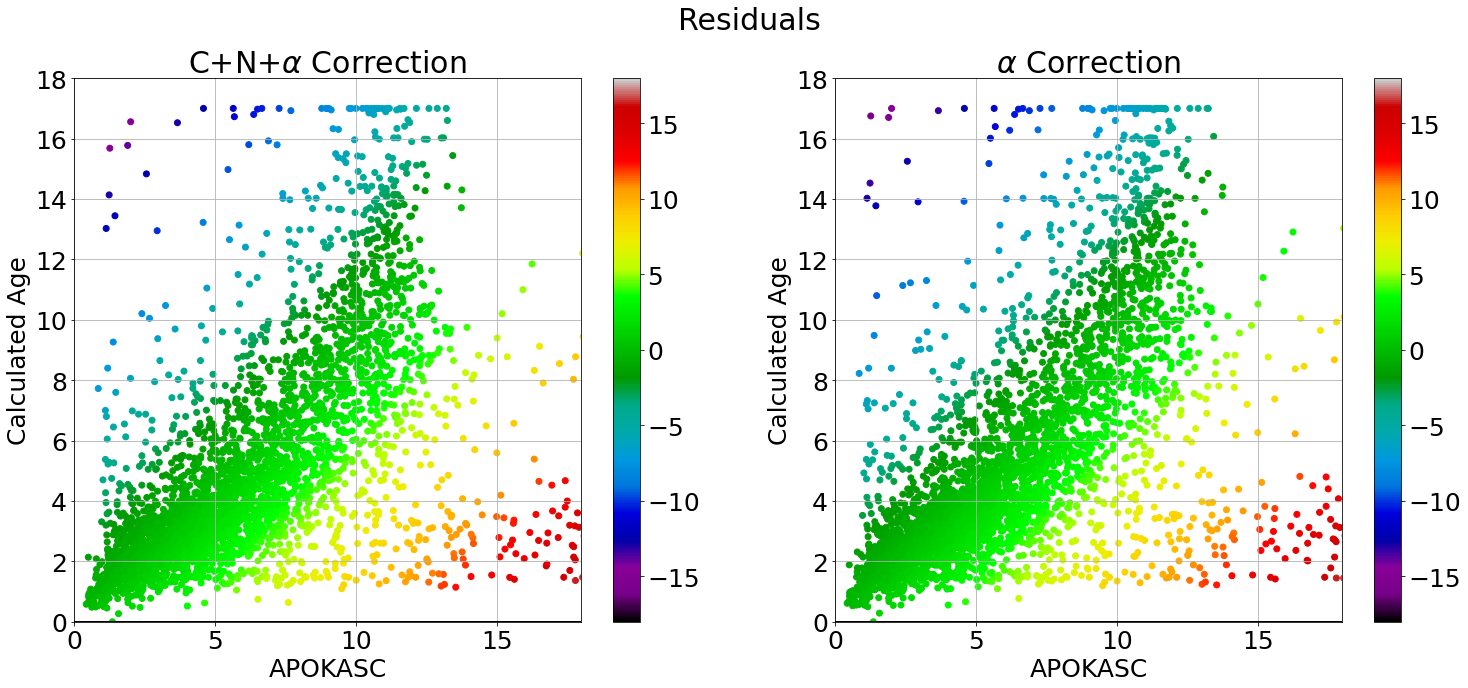

In [53]:
plt.figure(figsize=[25,10])
plt.suptitle(r'Residuals')

plt.subplot(121)
plt.scatter(kasc3['IntAge'],agesCN['AGE'],c=kasc3['IntAge']-agesCN['AGE'],cmap='nipy_spectral',vmax=18,vmin=-18)
plt.colorbar()
plt.axhline(0,c='k',lw=3.0)
plt.xlim(0,18)
plt.ylim(0,18)
plt.grid()
plt.title(r'C+N+$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.subplot(122)
plt.scatter(kasc3['IntAge'],ages['AGE'],c=kasc3['IntAge']-ages['AGE'],cmap='nipy_spectral',vmax=18,vmin=-18)
plt.colorbar()
plt.axhline(0,c='k',lw=3.0)
plt.ylim(0,18)
plt.xlim(0,18)
plt.grid()
plt.title(r'$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.savefig('../plots/age_age_resid_2panels.pdf',dpi=300,bbox_inches='tight')
plt.show()

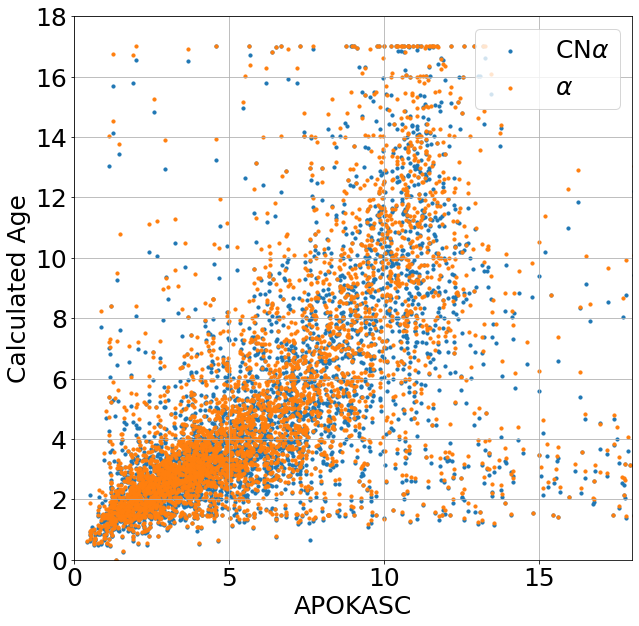

In [54]:
plt.figure(figsize=[10,10])
plt.scatter(kasc3['IntAge'],agesCN['AGE'],s=10,label=r'CN$\alpha$')
plt.scatter(kasc3['IntAge'],ages['AGE'],s=10,label=r'$\alpha$')
plt.legend()
# plt.axhline(0,c='k',lw=3.0)
plt.xlim(0,18)
plt.ylim(0,18)
plt.grid()
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')
plt.savefig('../plots/age_ageCombineCNNo.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [55]:
kasc3.columns

<TableColumns names=('KICID','Mass','Logg','Fe/H','Al/Fe','Teff','C/N','M_err','Logg_err','Fe/H_err','Al/Fe_err','Teff_err','2MASSID','IntTeff','IntML','IntAge','IntC12','IntC13','IntN14','IntXsurf')>

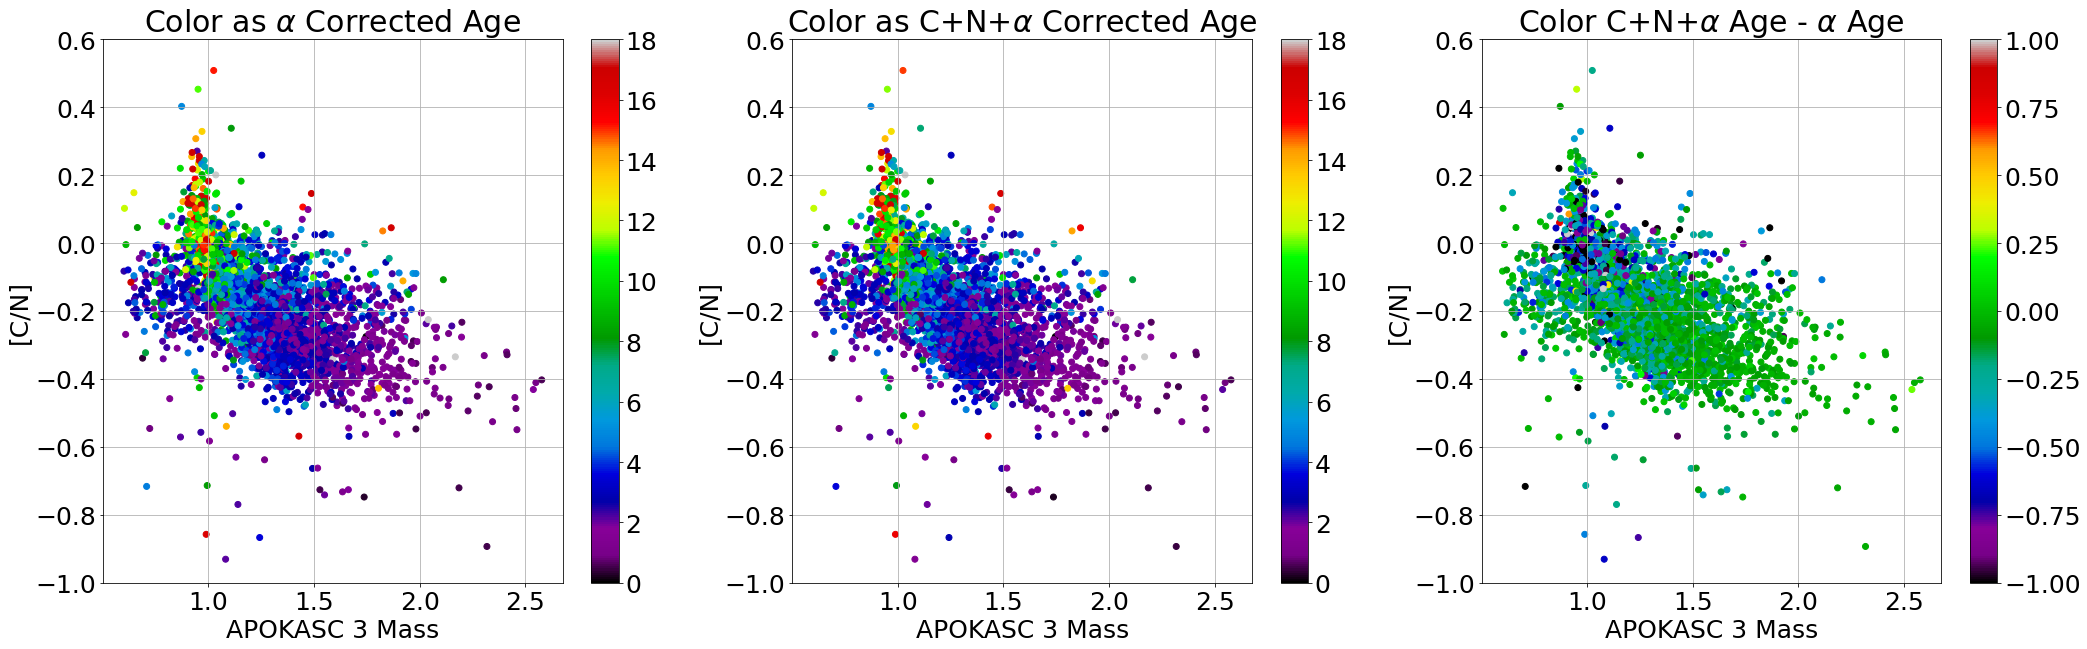

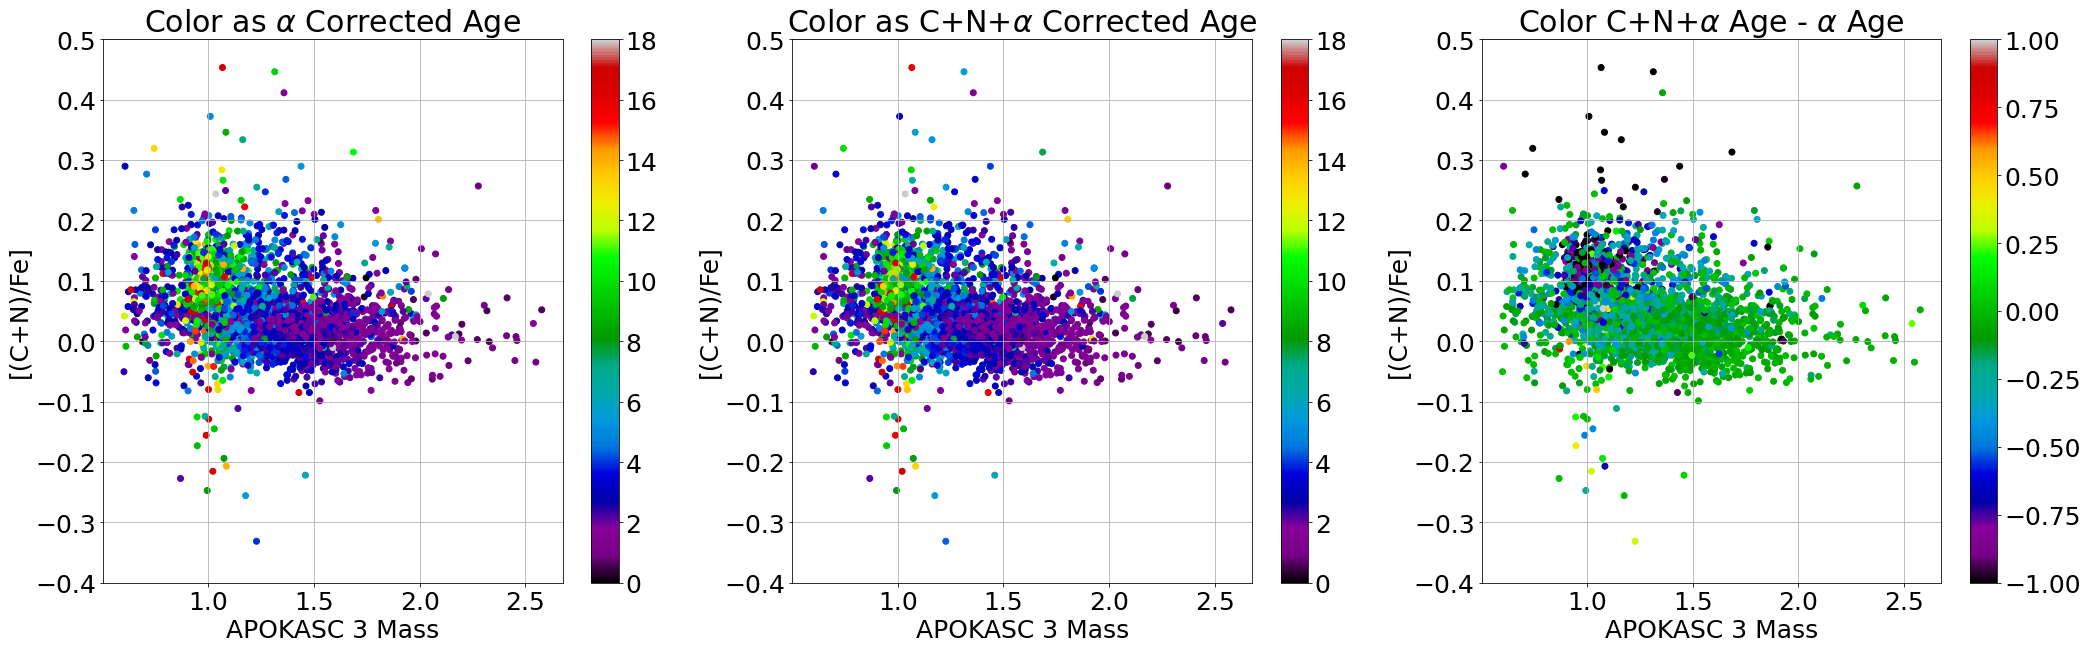

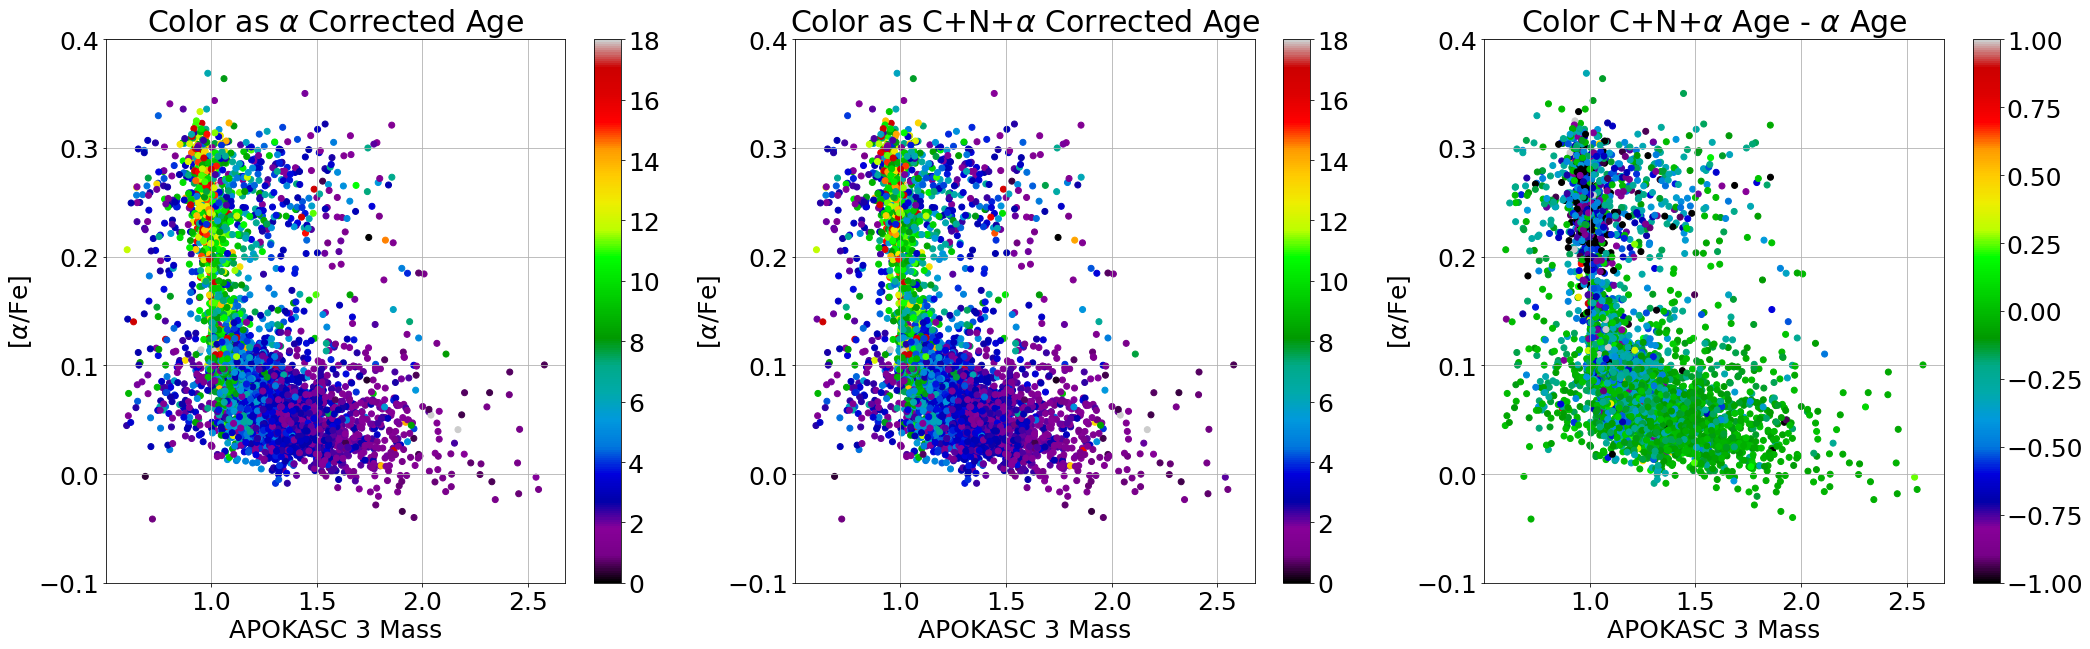

In [56]:
plt.figure(figsize=[35,10])
plt.subplot(131)
plt.scatter(kasc3['Mass'],kasc3dr17['C_FE']-kasc3dr17['N_FE'],c=ages['AGE'],vmax=18,cmap='nipy_spectral')
plt.colorbar()
plt.ylim(-1,0.6)
plt.title(r'Color as $\alpha$ Corrected Age')
plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'[C/N]')
plt.grid()
plt.subplot(132)
plt.scatter(kasc3['Mass'],kasc3dr17['C_FE']-kasc3dr17['N_FE'],c=agesCN['AGE'],vmax=18,cmap='nipy_spectral')
plt.colorbar()
plt.ylim(-1,0.6)
plt.title(r'Color as C+N+$\alpha$ Corrected Age')
plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'[C/N]')
plt.grid()
plt.subplot(133)
plt.scatter(kasc3['Mass'],kasc3dr17['C_FE']-kasc3dr17['N_FE'],c=agesCN['AGE']-ages['AGE'],cmap='nipy_spectral',
            vmin=-1,vmax=1)
plt.colorbar()
plt.ylim(-1,0.6)
plt.title(r'Color C+N+$\alpha$ Age - $\alpha$ Age')
plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'[C/N]')
plt.grid()
plt.savefig('masscn.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[35,10])
plt.subplot(131)
plt.scatter(kasc3['Mass'],cnfe,c=ages['AGE'],vmax=18,cmap='nipy_spectral')
plt.colorbar()
plt.ylim(-0.4,0.5)
plt.title(r'Color as $\alpha$ Corrected Age')
plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'[(C+N)/Fe]')
plt.grid()
plt.subplot(132)
plt.scatter(kasc3['Mass'],cnfe,c=agesCN['AGE'],vmax=18,cmap='nipy_spectral')
plt.colorbar()
plt.ylim(-0.4,0.5)
plt.title(r'Color as C+N+$\alpha$ Corrected Age')
plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'[(C+N)/Fe]')
plt.grid()
plt.subplot(133)
plt.scatter(kasc3['Mass'],cnfe,c=agesCN['AGE']-ages['AGE'],cmap='nipy_spectral',vmin=-1,vmax=1)
plt.colorbar()
plt.title(r'Color C+N+$\alpha$ Age - $\alpha$ Age')
plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'[(C+N)/Fe]')
plt.ylim(-0.4,0.5)
plt.grid()
plt.savefig('masscnfe.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[35,10])
plt.subplot(131)
plt.scatter(kasc3['Mass'],kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H'],
            c=ages['AGE'],vmax=18,cmap='nipy_spectral')
plt.colorbar()
plt.ylim(-0.1,0.4)
plt.title(r'Color as $\alpha$ Corrected Age')
plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'[$\alpha$/Fe]')
plt.grid()
plt.subplot(132)
plt.scatter(kasc3['Mass'],kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H'],
            c=agesCN['AGE'],vmax=18,cmap='nipy_spectral')
plt.colorbar()
plt.ylim(-0.1,0.4)
plt.title(r'Color as C+N+$\alpha$ Corrected Age')
plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'[$\alpha$/Fe]')
plt.grid()
plt.subplot(133)
plt.scatter(kasc3['Mass'],kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H'],
            c=agesCN['AGE']-ages['AGE'],cmap='nipy_spectral',vmin=-1,vmax=1)
plt.colorbar()
plt.title(r'Color C+N+$\alpha$ Age - $\alpha$ Age')
plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'[$\alpha$/Fe]')
plt.ylim(-0.1,0.4)
plt.grid()
plt.savefig('massafe.pdf',dpi=300,bbox_inches='tight')
plt.show()

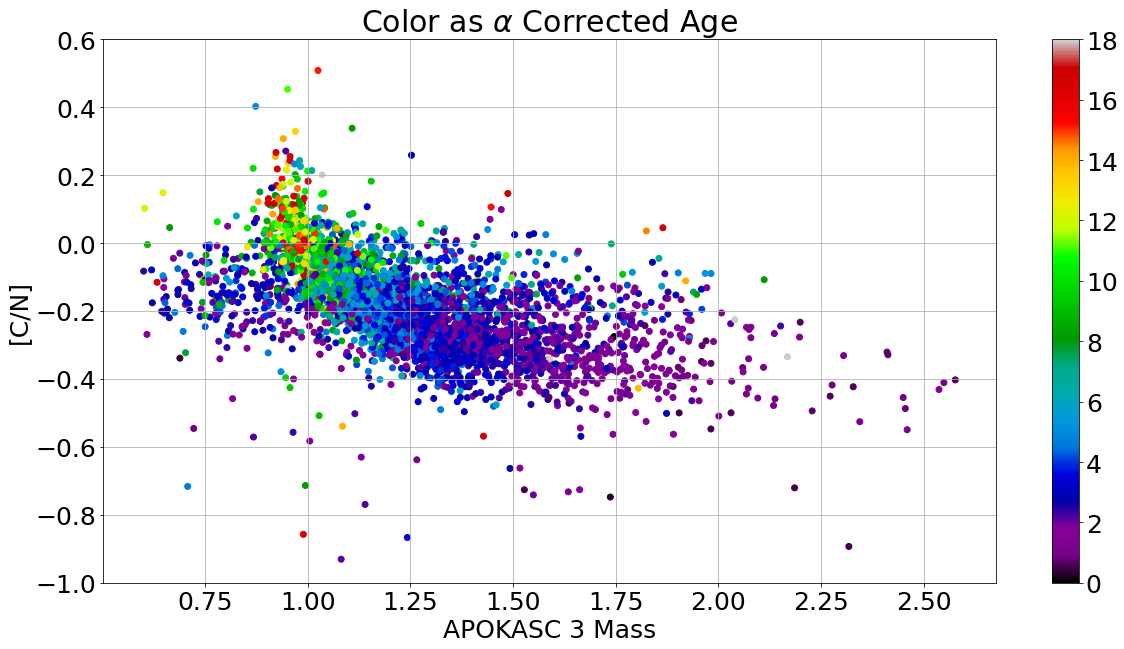

In [57]:
plt.figure(figsize=[20,10])
plt.scatter(kasc3['Mass'],kasc3dr17['C_FE']-kasc3dr17['N_FE'],c=ages['AGE'],vmax=18,cmap='nipy_spectral')
plt.colorbar()
plt.ylim(-1,0.6)
plt.title(r'Color as $\alpha$ Corrected Age')
plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'[C/N]')
plt.grid()
plt.show()

In [58]:
finger = np.where((kasc3['Mass']>=0.9)&(kasc3['Mass']<1.1)&(kasc3dr17['C_FE']-kasc3dr17['N_FE']>=0.)&
                  (ages['AGE']>=7.5))

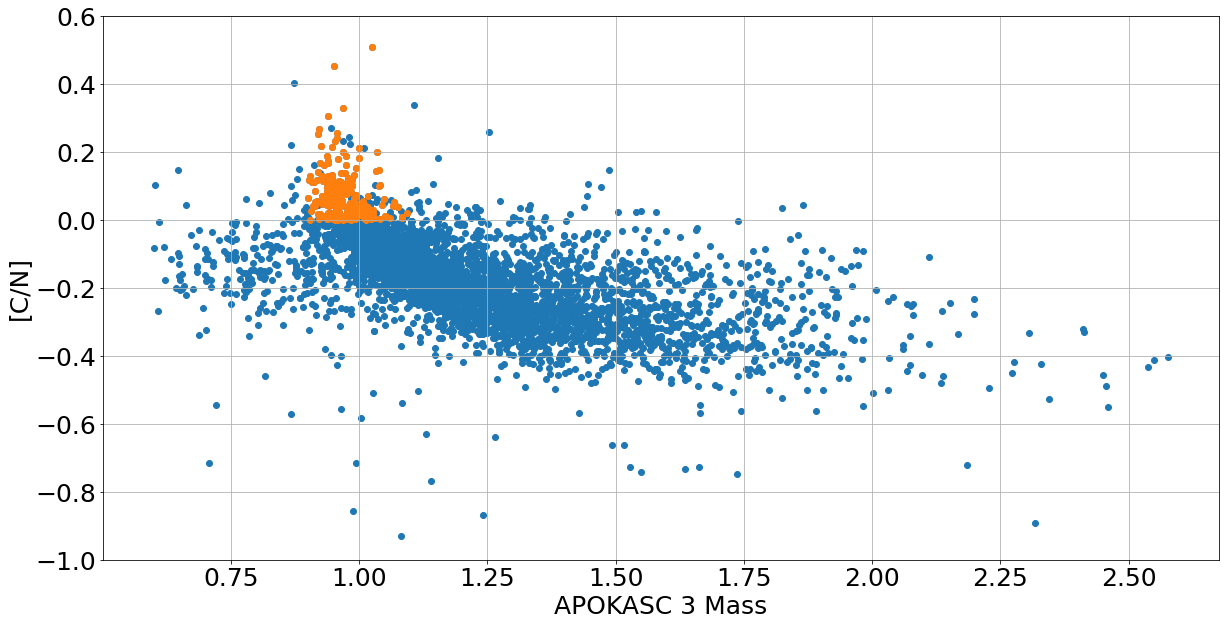

In [59]:
plt.figure(figsize=[20,10])
plt.scatter(kasc3['Mass'],kasc3dr17['C_FE']-kasc3dr17['N_FE'])#,c=ages['AGE'],vmax=18,cmap='nipy_spectral')
plt.scatter(kasc3['Mass'][finger],(kasc3dr17['C_FE']-kasc3dr17['N_FE'])[finger])
# plt.colorbar()
plt.ylim(-1,0.6)
# plt.title(r'Color as $\alpha$ Corrected Age')
plt.xlabel(r'APOKASC 3 Mass')
plt.ylabel(r'[C/N]')
plt.grid()
plt.show()

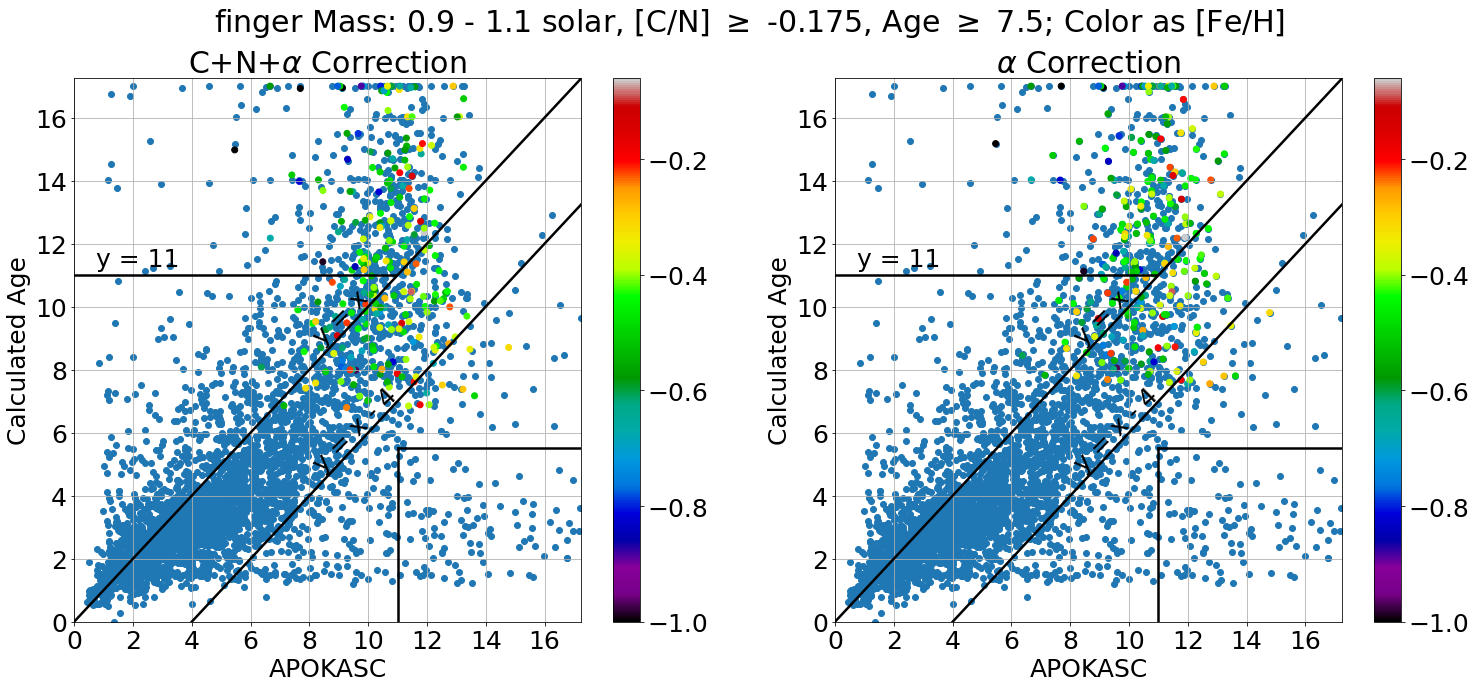

Median [Fe/H]:  -0.48234499


In [60]:
plt.figure(figsize=[25,10])
plt.suptitle(r'finger Mass: 0.9 - 1.1 solar, [C/N] $\geq$ -0.175, Age $\geq$ 7.5; Color as [Fe/H]')

plt.subplot(121)
plt.scatter(kasc3['IntAge'],ages['AGE'],c='tab:blue')
plt.scatter(kasc3['IntAge'][finger],agesCN['AGE'][finger],c=kasc3dr17['FE_H'][finger],cmap='nipy_spectral',vmin=-1.)
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)
plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'C+N+$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.subplot(122)
plt.scatter(kasc3['IntAge'],ages['AGE'],c='tab:blue')
plt.scatter(kasc3['IntAge'][finger],ages['AGE'][finger],c=kasc3dr17['FE_H'][finger],cmap='nipy_spectral',vmin=-1.)
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')
plt.show()
print('Median [Fe/H]: ',np.nanmedian(kasc3dr17['FE_H'][finger]))

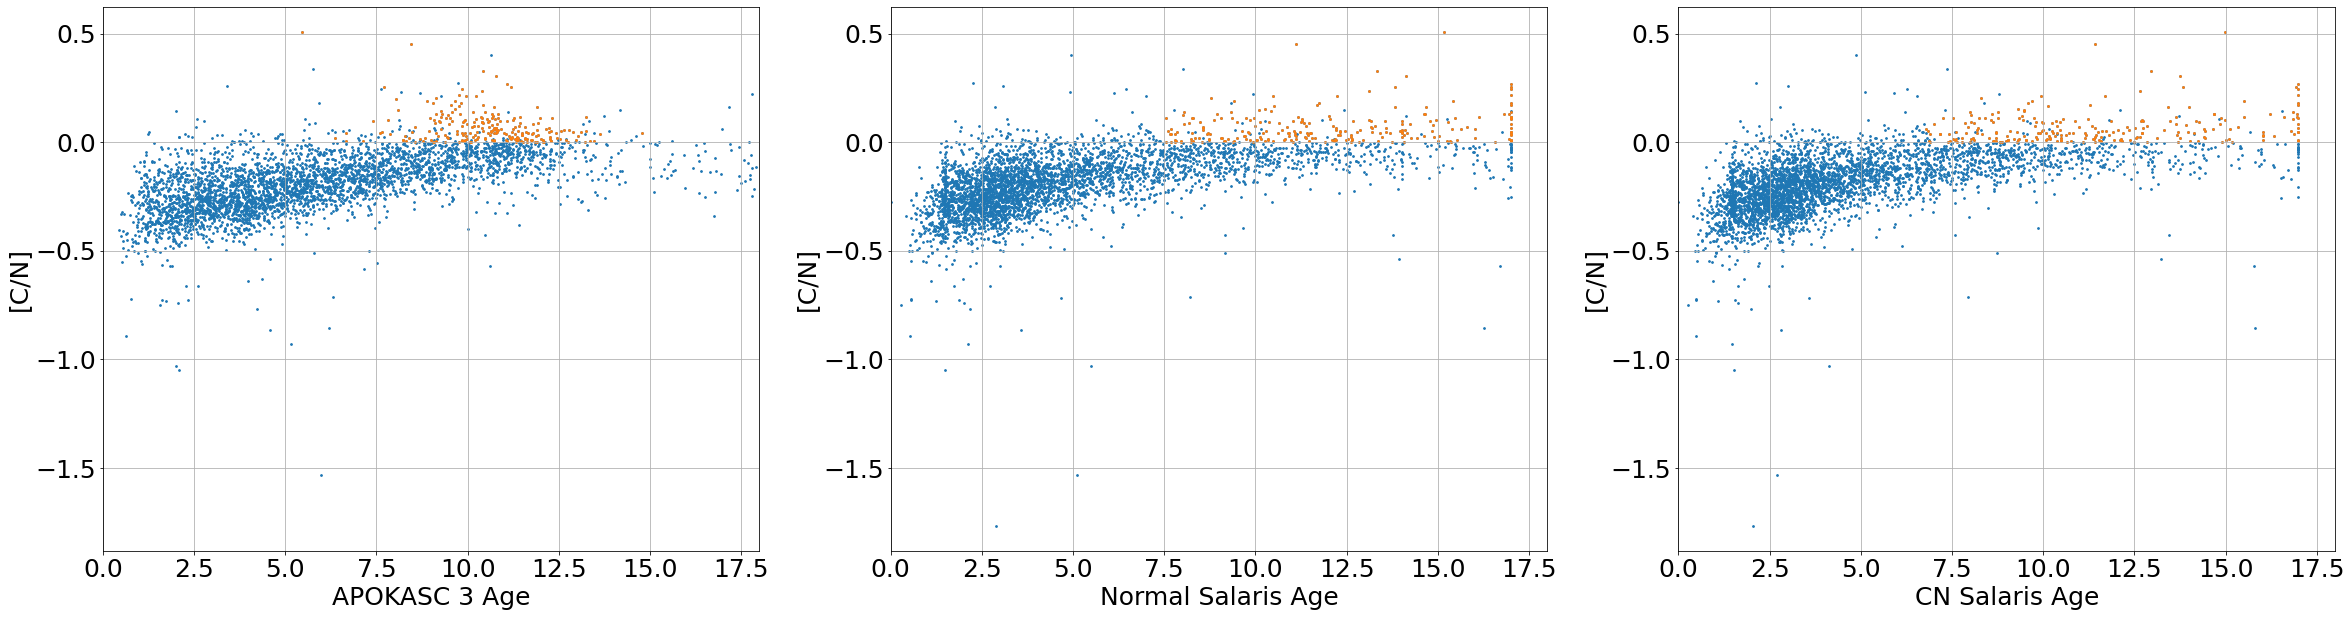

In [61]:
plt.figure(figsize=(40,10))
plt.subplot(131)
plt.scatter(kasc3['IntAge'],kasc3dr17['C_FE']-kasc3dr17['N_FE'],s=3)
plt.scatter(kasc3['IntAge'][finger],(kasc3dr17['C_FE']-kasc3dr17['N_FE'])[finger],s=3,label='Finger')
plt.xlim(0,18)
plt.xlabel(r'APOKASC 3 Age')
plt.ylabel(r'[C/N]')
plt.grid()

plt.subplot(132)
plt.scatter(ages['AGE'],kasc3dr17['C_FE']-kasc3dr17['N_FE'],s=3)
plt.scatter(ages['AGE'][finger],(kasc3dr17['C_FE']-kasc3dr17['N_FE'])[finger],s=3,label='Finger')
plt.xlim(0,18)
plt.xlabel(r'Normal Salaris Age')
plt.ylabel(r'[C/N]')
plt.grid()

plt.subplot(133)
plt.scatter(agesCN['AGE'],kasc3dr17['C_FE']-kasc3dr17['N_FE'],s=3)
plt.scatter(agesCN['AGE'][finger],(kasc3dr17['C_FE']-kasc3dr17['N_FE'])[finger],s=3,label='Finger')
plt.xlim(0,18)
plt.xlabel(r'CN Salaris Age')
plt.ylabel(r'[C/N]')
plt.grid()

plt.savefig('age_CN_loc.pdf',dpi=300,bbox_inches='tight')

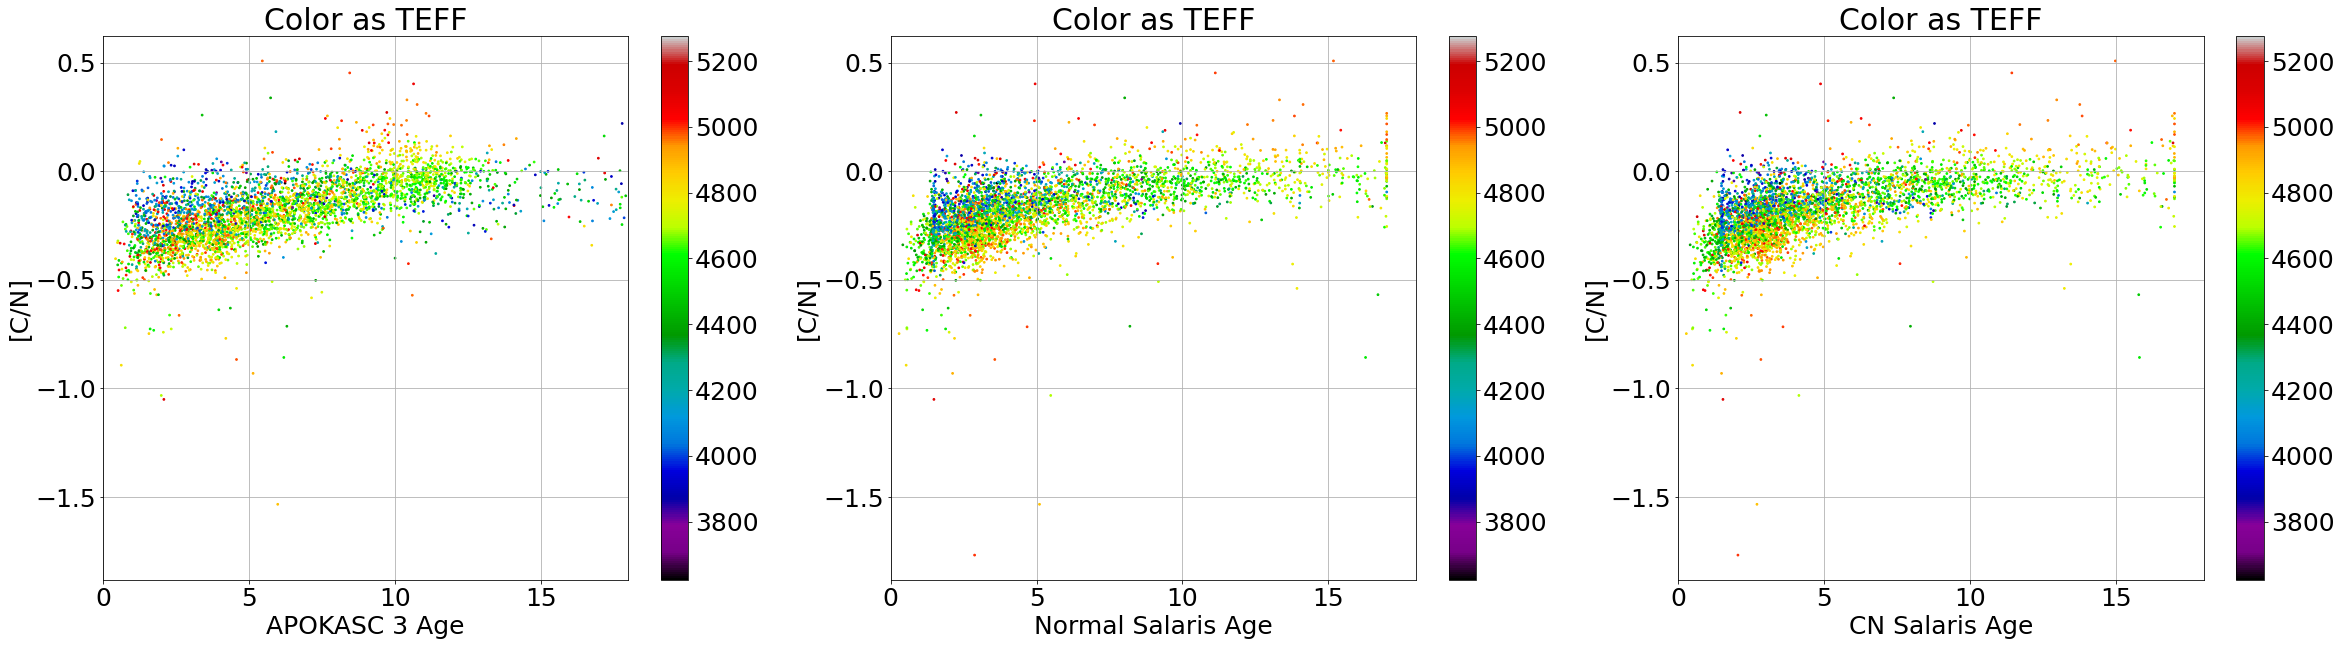

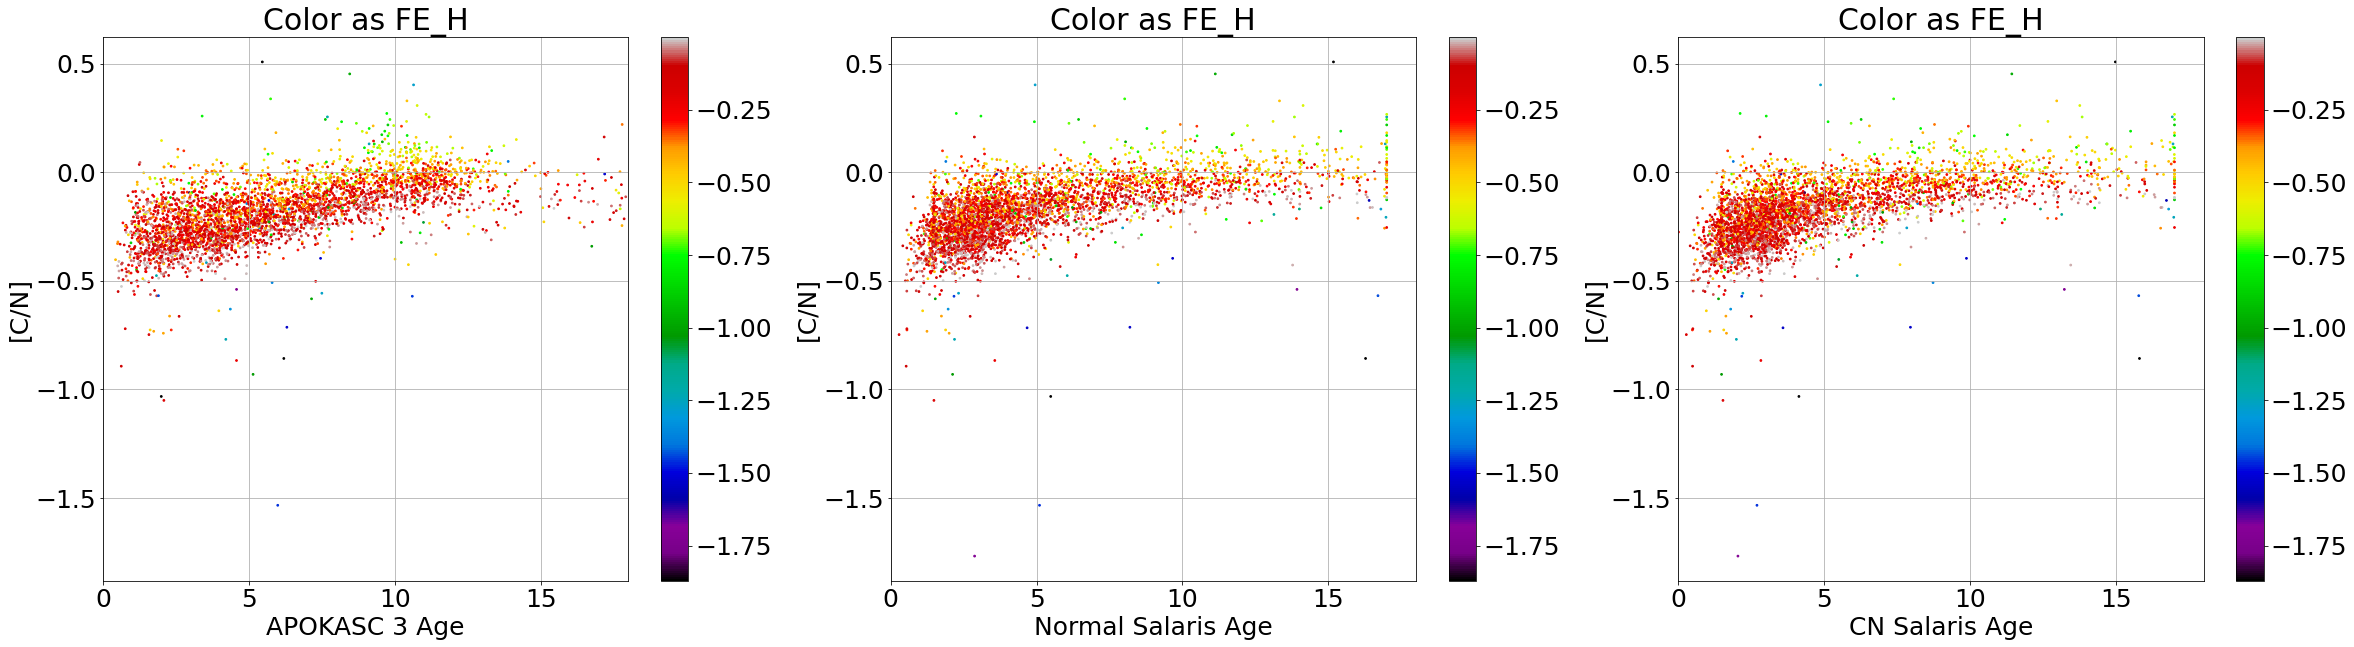

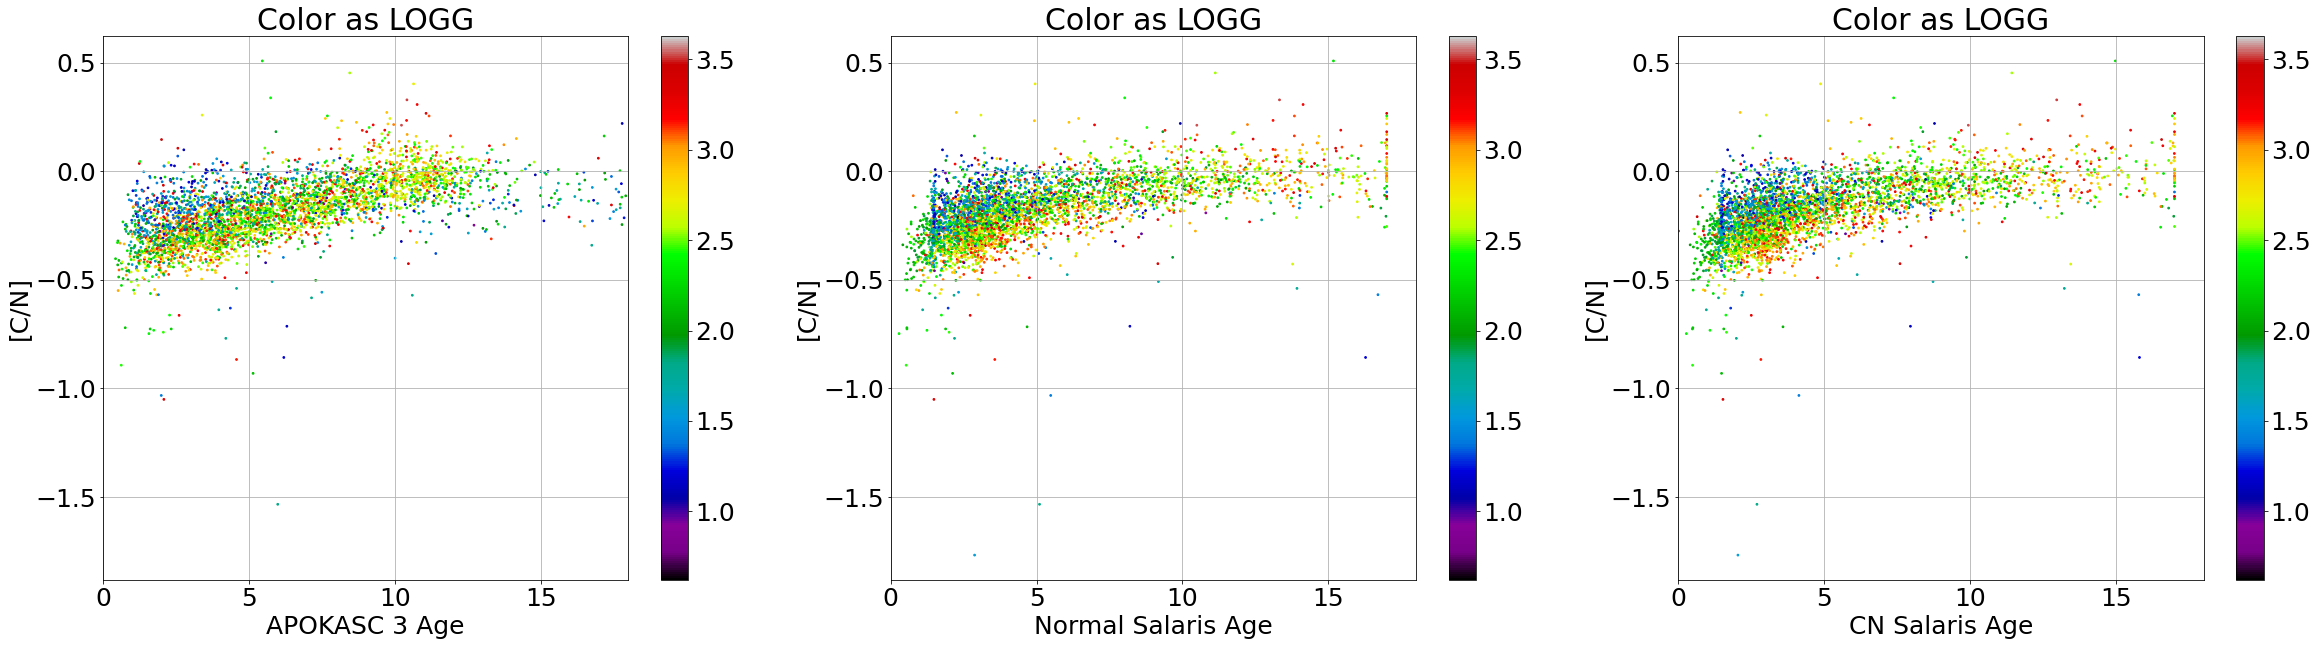

In [62]:
import matplotlib.patches as pat
pltcols = ['TEFF','FE_H','LOGG']

for i in range(len(pltcols)):
    plt.figure(figsize=(40,10))
    plt.subplot(131)
    plt.scatter(kasc3['IntAge'],kasc3dr17['C_FE']-kasc3dr17['N_FE'],
                c=kasc3dr17[pltcols[i]],cmap='nipy_spectral',s=3)
    plt.colorbar()
    plt.xlim(0,18)
    plt.title(r'Color as {}'.format(pltcols[i]))
    plt.xlabel(r'APOKASC 3 Age')
    plt.ylabel(r'[C/N]')
    plt.grid()
    
    plt.subplot(132)
    plt.scatter(ages['AGE'],kasc3dr17['C_FE']-kasc3dr17['N_FE'],
                c=kasc3dr17[pltcols[i]],cmap='nipy_spectral',s=3)
    plt.colorbar()
    plt.xlim(0,18)
    plt.title(r'Color as {}'.format(pltcols[i]))
    plt.xlabel(r'Normal Salaris Age')
    plt.ylabel(r'[C/N]')
    plt.grid()
    
    plt.subplot(133)
    plt.scatter(agesCN['AGE'],kasc3dr17['C_FE']-kasc3dr17['N_FE'],
                c=kasc3dr17[pltcols[i]],cmap='nipy_spectral',s=3)
    plt.colorbar()
    plt.xlim(0,18)
    plt.title(r'Color as {}'.format(pltcols[i]))
    plt.xlabel(r'CN Salaris Age')
    plt.ylabel(r'[C/N]')
    plt.grid()
    
    plt.savefig('age_CN_{}.pdf'.format(pltcols[i]),dpi=300,bbox_inches='tight')
    plt.show()

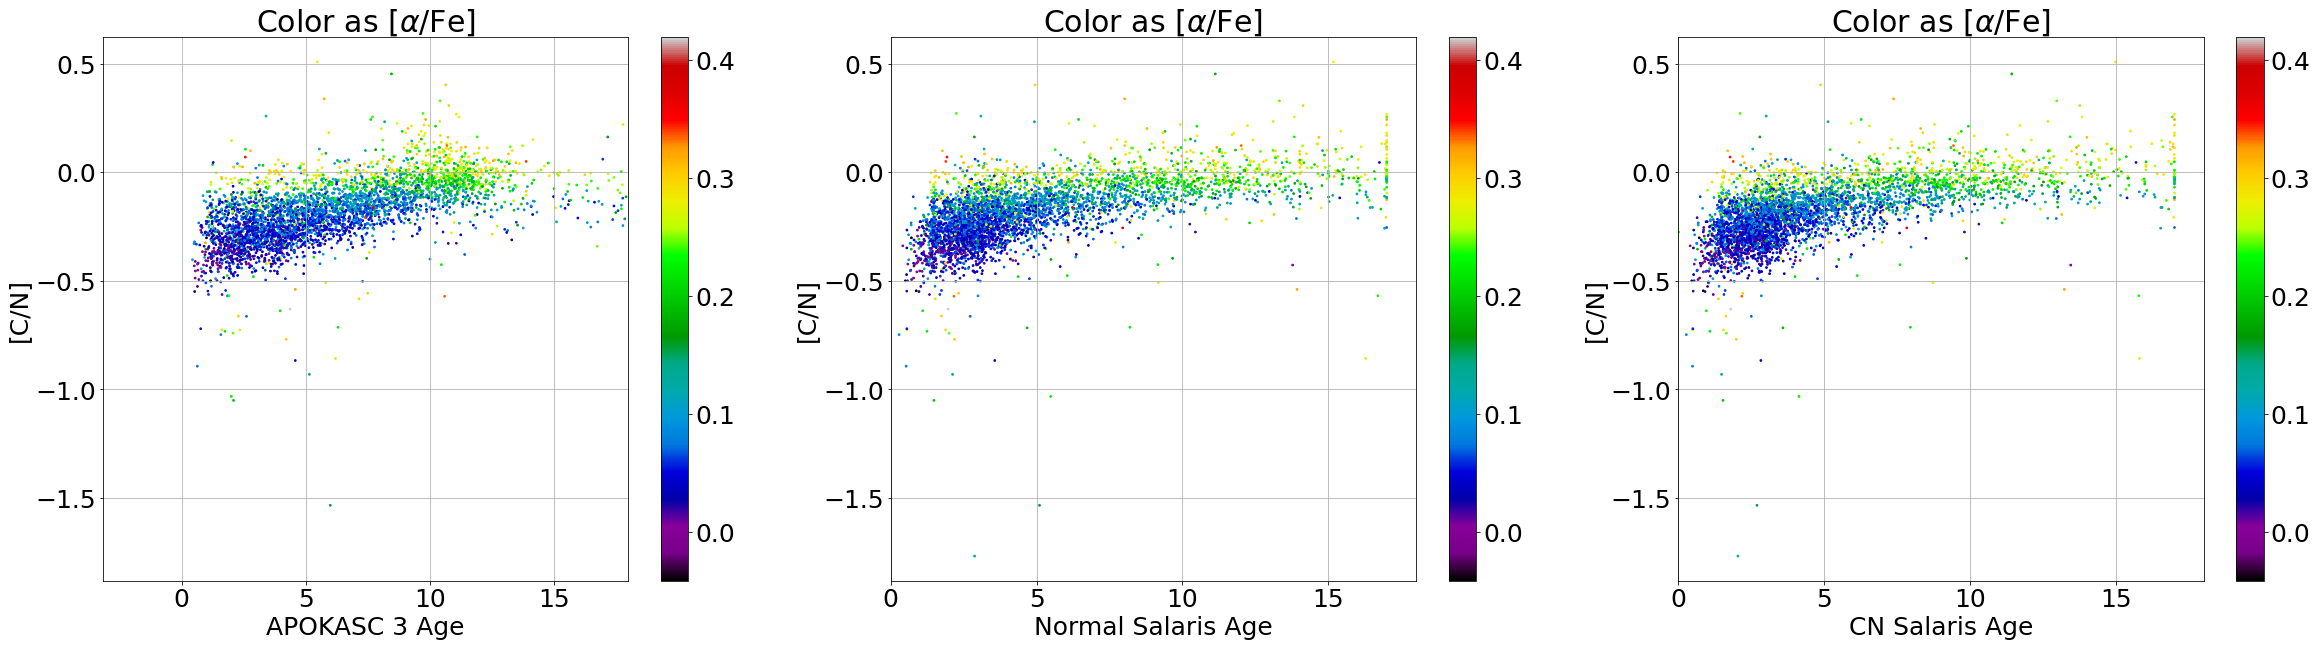

In [63]:
plt.figure(figsize=[40,10])
plt.subplot(131)
plt.scatter(kasc3['IntAge'],kasc3dr17['C_FE']-kasc3dr17['N_FE'],c=apoafe,cmap='nipy_spectral',s=3)
plt.colorbar()
plt.xlim(right=18)
plt.title(r'Color as [$\alpha$/Fe]')
plt.xlabel(r'APOKASC 3 Age')
plt.ylabel(r'[C/N]')
plt.grid()

plt.subplot(132)
plt.scatter(ages['AGE'],kasc3dr17['C_FE']-kasc3dr17['N_FE'],c=apoafe,cmap='nipy_spectral',s=3)
plt.colorbar()
plt.xlim(0,18)
plt.title(r'Color as [$\alpha$/Fe]')
plt.xlabel(r'Normal Salaris Age')
plt.ylabel(r'[C/N]')
plt.grid()

plt.subplot(133)
plt.scatter(agesCN['AGE'],kasc3dr17['C_FE']-kasc3dr17['N_FE'],c=apoafe,cmap='nipy_spectral',s=3)
plt.colorbar()
plt.xlim(0,18)
plt.title(r'Color as [$\alpha$/Fe]')
plt.xlabel(r'CN Salaris Age')
plt.ylabel(r'[C/N]')
plt.grid()

plt.savefig('age_CN_alpha.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
solar = np.where((kasc3['Mass']>=1.0)&(kasc3['Mass']<1.5)&(kasc3dr17['FE_H']>-0.01)&(kasc3dr17['FE_H']<0.0))

In [ ]:
plt.figure(figsize=[25,10])
plt.suptitle(r'Solar like Stars: 1.0 - 1.5 $M_\odot$; -0.01 - 0.0 [Fe/H]; Color as [Fe/H]')

plt.subplot(121)
plt.scatter(kasc3['IntAge'][solar],agesCN['AGE'][solar],c=kasc3dr17['FE_H'][solar],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)
plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'C+N+$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.subplot(122)
plt.scatter(kasc3['IntAge'][solar],ages['AGE'][solar],c=kasc3dr17['FE_H'][solar],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.savefig('ageage_solfeh.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=[25,10])
plt.suptitle(r'Solar like Stars: 1.0 - 1.5 $M_\odot$; -0.01 - 0.0 [Fe/H]; Color as [(C+N)/Fe]')

plt.subplot(121)
plt.scatter(kasc3['IntAge'][solar],agesCN['AGE'][solar],c=cnfe[solar],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)
plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'C+N+$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.subplot(122)
plt.scatter(kasc3['IntAge'][solar],ages['AGE'][solar],c=cnfe[solar],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.savefig('ageage_solcnfe.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=[25,10])
plt.suptitle(r'Solar like Stars: 1.0 - 1.5 $M_\odot$; -0.01 - 0.0 [Fe/H]; Color as [C/N]')

plt.subplot(121)
plt.scatter(kasc3['IntAge'][solar],agesCN['AGE'][solar],
            c=(kasc3dr17['C_FE']-kasc3dr17['N_FE'])[solar],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)
plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'C+N+$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.subplot(122)
plt.scatter(kasc3['IntAge'][solar],ages['AGE'][solar],
            c=(kasc3dr17['C_FE']-kasc3dr17['N_FE'])[solar],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.savefig('ageage_solcn.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=[12,10])
plt.scatter((kasc3dr17['ALPHA_M']-kasc3dr17['M_H']+kasc3dr17['FE_H'])[solar],
(kasc3dr17['C_FE']-kasc3dr17['N_FE'])[solar],c=ages['AGE'][solar],cmap='nipy_spectral')
plt.colorbar()
plt.xlabel(r'[$\alpha$/Fe]')
plt.ylabel(r'[C/N]')

In [ ]:
plt.figure(figsize=[25,10])
plt.suptitle(r'Solar like Stars: 1.0 - 1.5 $M_\odot$; -0.01 - 0.0 [Fe/H]; Color as Log(g)')

plt.subplot(121)
plt.scatter(kasc3['IntAge'][solar],agesCN['AGE'][solar],
            c=kasc3dr17['LOGG'][solar],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)
plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'C+N+$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.subplot(122)
plt.scatter(kasc3['IntAge'][solar],ages['AGE'][solar],
            c=kasc3dr17['LOGG'][solar],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.savefig('ageage_sollogg.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=[25,10])
plt.suptitle(r'Solar like Stars: 1.0 - 1.5 $M_\odot$; -0.01 - 0.0 [Fe/H]; Color as Teff')

plt.subplot(121)
plt.scatter(kasc3['IntAge'][solar],agesCN['AGE'][solar],
            c=kasc3dr17['TEFF'][solar],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)
plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'C+N+$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.subplot(122)
plt.scatter(kasc3['IntAge'][solar],ages['AGE'][solar],
            c=kasc3dr17['TEFF'][solar],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.savefig('ageage_solteff.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=[25,10])
plt.suptitle(r'Solar like Stars: 1.0 - 1.5 $M_\odot$; -0.01 - 0.0 [Fe/H]; Color as [$\alpha$/Fe]')

plt.subplot(121)
plt.scatter(kasc3['IntAge'][solar],agesCN['AGE'][solar],
            c=(kasc3dr17['ALPHA_M']-kasc3dr17['M_H']+kasc3dr17['FE_H'])[solar],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)
plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'C+N+$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.subplot(122)
plt.scatter(kasc3['IntAge'][solar],ages['AGE'][solar],
            c=(kasc3dr17['ALPHA_M']-kasc3dr17['M_H']+kasc3dr17['FE_H'])[solar],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0,0],[18,18],c='k')
plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.grid()

plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

plt.title(r'$\alpha$ Correction')
plt.xlabel(r'APOKASC')
plt.ylabel(r'Calculated Age')

plt.savefig('ageage_solafe.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=[7,5])
plt.scatter(ages['AGE'],kasc3dr17['ALPHA_M']-kasc3dr17['M_H']+kasc3dr17['FE_H'])
plt.xlim(0,17.25)
plt.title(r'$\alpha$ Corrected')
plt.xlabel(r'Age')
plt.ylabel(r'[$\alpha$/Fe]')
plt.show()

plt.figure(figsize=[7,5])
plt.scatter(agesCN['AGE'],kasc3dr17['ALPHA_M']-kasc3dr17['M_H']+kasc3dr17['FE_H'])
plt.xlim(0,17.25)
plt.title(r'C+N+$\alpha$ Corrected')
plt.xlabel(r'Age')
plt.ylabel(r'[$\alpha$/Fe]')
plt.show()

plt.figure(figsize=[7,5])
plt.scatter(kasc3['IntAge'],kasc3dr17['ALPHA_M']-kasc3dr17['M_H']+kasc3dr17['FE_H'])
plt.xlim(0,17.25)
plt.title(r'APOKASC')
plt.xlabel(r'Age')
plt.ylabel(r'[$\alpha$/Fe]')
plt.show()

In [ ]:
plt.figure(figsize=[7,5])
plt.scatter(np.log10(ages['AGE']*10**9),kasc3dr17['ALPHA_M']-kasc3dr17['M_H']+kasc3dr17['FE_H'])
plt.xlim(8,10.5)
plt.title(r'$\alpha$ Corrected')
plt.xlabel(r'Age')
plt.ylabel(r'[$\alpha$/Fe]')
plt.show()

plt.figure(figsize=[7,5])
plt.scatter(np.log10(agesCN['AGE']*10**9),kasc3dr17['ALPHA_M']-kasc3dr17['M_H']+kasc3dr17['FE_H'])
plt.xlim(8,10.5)
plt.title(r'C+N+$\alpha$ Corrected')
plt.xlabel(r'Age')
plt.ylabel(r'[$\alpha$/Fe]')
plt.show()

plt.figure(figsize=[7,5])
plt.scatter(np.log10(kasc3['IntAge']*10**9),kasc3dr17['ALPHA_M']-kasc3dr17['M_H']+kasc3dr17['FE_H'])
plt.xlim(8,10.5)
plt.title(r'APOKASC')
plt.xlabel(r'Age')
plt.ylabel(r'[$\alpha$/Fe]')
plt.show()

In [ ]:
plt.figure(figsize=[7,5])
plt.scatter(ages['AGE'],kasc3dr17['FE_H'])
plt.xlim(0,17.25)
plt.title(r'$\alpha$ Corrected')
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]')
plt.show()

plt.figure(figsize=[7,5])
plt.scatter(agesCN['AGE'],kasc3dr17['FE_H'])
plt.xlim(0,17.25)
plt.title(r'C+N+$\alpha$ Corrected')
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]')
plt.show()

plt.figure(figsize=[7,5])
plt.scatter(kasc3['IntAge'],kasc3dr17['FE_H'])
plt.xlim(0,17.25)
plt.title(r'APOKASC')
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]')
plt.show()

In [ ]:
plt.figure(figsize=[7,5])
plt.scatter(np.log10(ages['AGE']*10**9),kasc3dr17['FE_H'])
plt.xlim(8,10.5)
plt.title(r'$\alpha$ Corrected')
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]')
plt.show()

plt.figure(figsize=[7,5])
plt.scatter(np.log10(agesCN['AGE']*10**9),kasc3dr17['FE_H'])
plt.xlim(8,10.5)
plt.title(r'C+N+$\alpha$ Corrected')
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]')
plt.show()

plt.figure(figsize=[7,5])
plt.scatter(np.log10(kasc3['IntAge']*10**9),kasc3dr17['FE_H'])
plt.xlim(8,10.5)
plt.title(r'APOKASC')
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]')
plt.show()